# Классификация данных Speedtest
В рамках данного ноутбука поработаем непосредственно с обработанными данными.

## Подготовка к работе
Оптимизируем дальнейший код и сразу заполним пространство всем необходимым функционалом.

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

import seaborn as sns
from matplotlib import pyplot as plt

2023-05-13 15:53:59.390447: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 15:54:00.080164: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def check_folder_name(folder_name: str) -> str:
    """If folder not exists - create, after return path"""

    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    return folder_name

In [3]:
SEED = 0  # to reproduce building
BATCH_SIZE = 64

FIG_SIZE = (38.4,21.6)  # 3810x2160

DATA_PATH = 'data/merged'
LOGS_PATH = check_folder_name('logs/merged')
VISUAL_PATH = check_folder_name('visual/model/merged')
MODEL_PATH = check_folder_name('model/merged')

In [4]:
sns.set_theme(palette='winter', font='jost', font_scale=3, rc={'figure.figsize': FIG_SIZE})

### Подготовка датасета
Загрузим датасет, отсортируем значения по годам и уровню ВВП и уберём лишние признаки

In [5]:
df = pd.read_csv(f'{DATA_PATH}/fixed/fixed_merged.csv').sort_values(by=['year', 'income'])
df.head()

,iso_a3,year,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,label,income,group,continent
0,VEN,2019,18136.0,16625.0,14.0,1,1,Venezuela,84.34119,Low income,South America
1,VEN,2019,35595.0,7792.0,686.0,1,1,Venezuela,84.34119,Low income,South America
2,VEN,2019,38425.0,1888.0,745.0,1,1,Venezuela,84.34119,Low income,South America
3,VEN,2019,764.0,502.0,108.0,1,1,Venezuela,84.34119,Low income,South America
4,VEN,2019,26352.5,6077.0,689.5,8,4,Venezuela,84.34119,Low income,South America


Сбалансируем датасет, приведя группы к единому размеру и сократив его до 200 000 наблюдений на группу

In [6]:
df = pd.concat([df_group[1].sample(n=50_000) for df_group in df.groupby(['group', 'year'], sort=False)])
df.groupby('group').describe().T

group               High income     Low income  Lower-middle income  \
year       count  200000.000000  200000.000000        200000.000000   
           mean     2020.500000    2020.500000          2020.500000   
           std         1.118037       1.118037             1.118037   
           min      2019.000000    2019.000000          2019.000000   
           25%      2019.750000    2019.750000          2019.750000   
           50%      2020.500000    2020.500000          2020.500000   
           75%      2021.250000    2021.250000          2021.250000   
           max      2022.000000    2022.000000          2022.000000   
avg_d_kbps count  200000.000000  200000.000000        200000.000000   
           mean    90624.535870   14251.312712         25947.729815   
           std     97169.391633   18346.318806         29028.305692   
           min         1.000000       1.000000             1.000000   
           25%     19975.833333    3378.000000          7070.000000   
           50%     55491.250000    8877.000000         17989.250000   
           75%    131186.937500   19211.666667         35366.500000   
           max    941768.000000  738058.000000        629376.000000   
avg_u_kbps count  200000.000000  200000.000000        200000.000000   
           mean    34672.480400   12410.051504         24144.678660   
           std     60381.105430   16797.085750         29625.183462   
           min         1.000000       1.000000             1.000000   
           25%      5170.000000    1724.000000          3396.000000   
           50%     13096.000000    6702.500000         14336.833333   
           75%     32917.812500   17746.812500         36634.187500   
           max    936226.000000  554323.000000        624742.000000   
avg_lat_ms count  200000.000000  200000.000000        200000.000000   
           mean       41.796446      66.917153            33.651975   
           std       113.157940     152.297367            82.720335   
           min         0.000000       0.000000             0.000000   
           25%        12.000000      11.000000             7.750000   
           50%        18.500000      28.000000            18.000000   
           75%        31.000000      69.000000            37.000000   
           max      5050.000000   16523.500000          7290.000000   
tests      count  200000.000000  200000.000000        200000.000000   
           mean       41.375995      48.590100            82.593385   
           std       144.132276     186.724368           389.948623   
           min         1.000000       1.000000             1.000000   
           25%         2.000000       1.000000             2.000000   
           50%         6.000000       5.000000             6.000000   
           75%        30.000000      22.000000            30.000000   
           max     17675.000000    6757.000000         25322.000000   
devices    count  200000.000000  200000.000000        200000.000000   
           mean       11.659085      11.708355            19.728605   
           std        34.022979      42.168450            80.178471   
           min         1.000000       1.000000             1.000000   
           25%         1.000000       1.000000             1.000000   
           50%         3.000000       2.000000             3.000000   
           75%        10.000000       7.000000             9.000000   
           max      2633.000000    1891.000000          4630.000000   
income     count  200000.000000  200000.000000        200000.000000   
           mean    58157.128130    3019.764240          9779.001962   
           std     12219.810904    1503.475071          2582.460011   
           min     33770.650602      84.341190          4803.711174   
           25%     48723.638889    1770.123385          7389.056691   
           50%     62576.123031    3790.565840         10084.071293   
           75%     65325.674115    4165.639329         12167.993177   
           max    130002

Категоризируем целевой признак `group`

In [7]:
values, groups = pd.factorize(df.pop('group'))
df['group'] = values

print('\n'.join(f'{n} - {v}' for n, v in enumerate(groups)))

0 - Low income
1 - Lower-middle income
2 - Upper-middle income
3 - High income


Категоризируем качественный признак `continent` и переведём его в dummy-переменную

In [8]:
values, continents = pd.factorize(df.pop('continent'))
df = pd.concat([df, pd.DataFrame(tf.keras.utils.to_categorical(values, dtype='int8'), index=df.index, columns=continents)], axis=1)

print('\n'.join(f'{n} - {v}' for n, v in enumerate(continents)))

0 - South America
1 - Asia
2 - Africa
3 - North America
4 - Oceania
5 - Europe
6 - Seven seas (open ocean)


Уберём лишние колонки и перетасуем полученный датасет

In [9]:
df = df.drop(columns=['iso_a3', 'label', 'income']).sample(frac=1)
df.head()

,year,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,group,South America,Asia,Africa,North America,Oceania,Europe,Seven seas (open ocean)
4950084,2019,28286.0,7136.0,16.0,1,1,3,0,0,0,0,0,1,0
13167498,2020,16004.0,2710.5,23.0,59,23,2,0,0,0,1,0,0,0
32526021,2022,28612.0,27849.5,5.5,10,3,2,0,1,0,0,0,0,0
9685917,2020,21934.0,22574.0,6.0,1,1,1,0,1,0,0,0,0,0
2003907,2019,50672.0,26757.0,8.0,1,1,2,0,1,0,0,0,0,0


Построим корреляционную матрицу и посмотрим, как коррелируют полученные признаки друг с другом

In [62]:
fixed_correlation = df.corr(method='spearman').round(2)
fixed_correlation

,year,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,group,South America,Asia,Africa,North America,Oceania,Europe,Seven seas (open ocean)
year,1.00,0.21,0.21,-0.15,0.05,0.05,0.00,0.04,0.03,-0.04,0.00,-0.00,-0.04,-0.00
avg_d_kbps,0.21,1.00,0.81,-0.52,0.23,0.27,0.47,-0.20,0.02,-0.27,0.23,0.00,0.13,-0.00
avg_u_kbps,0.21,0.81,1.00,-0.60,0.21,0.24,0.19,-0.16,0.20,-0.25,-0.02,-0.03,0.10,-0.00
avg_lat_ms,-0.15,-0.52,-0.60,1.00,-0.03,-0.06,-0.11,0.11,-0.15,0.20,0.06,0.04,-0.11,-0.01
tests,0.05,0.23,0.21,-0.03,1.00,0.92,0.01,0.05,-0.01,-0.03,0.02,0.00,-0.03,0.00
devices,0.05,0.27,0.24,-0.06,0.92,1.00,0.04,0.04,-0.02,-0.04,0.03,0.01,-0.01,0.01
group,0.00,0.47,0.19,-0.11,0.01,0.04,1.00,-0.12,-0.36,-0.36,0.48,0.07,0.36,0.01
South America,0.04,-0.20,-0.16,0.11,0.05,0.04,-0.12,1.00,-0.30,-0.12,-0.15,-0.03,-0.17,-0.01
Asia,0.03,0.02,0.20,-0.15,-0.01,-0.02,-0.36,-0.30,1.00,-0.29,-0.37,-0.08,-0.42,-0.01
Africa,-0.04,-0.27,-0.25,0.20,-0.03,-0.04,-0.36,-0.12,-0.29,1.00,-0.15,-0.03,-0.17,-0.00


Выведем данную матрицу на тепловую карту

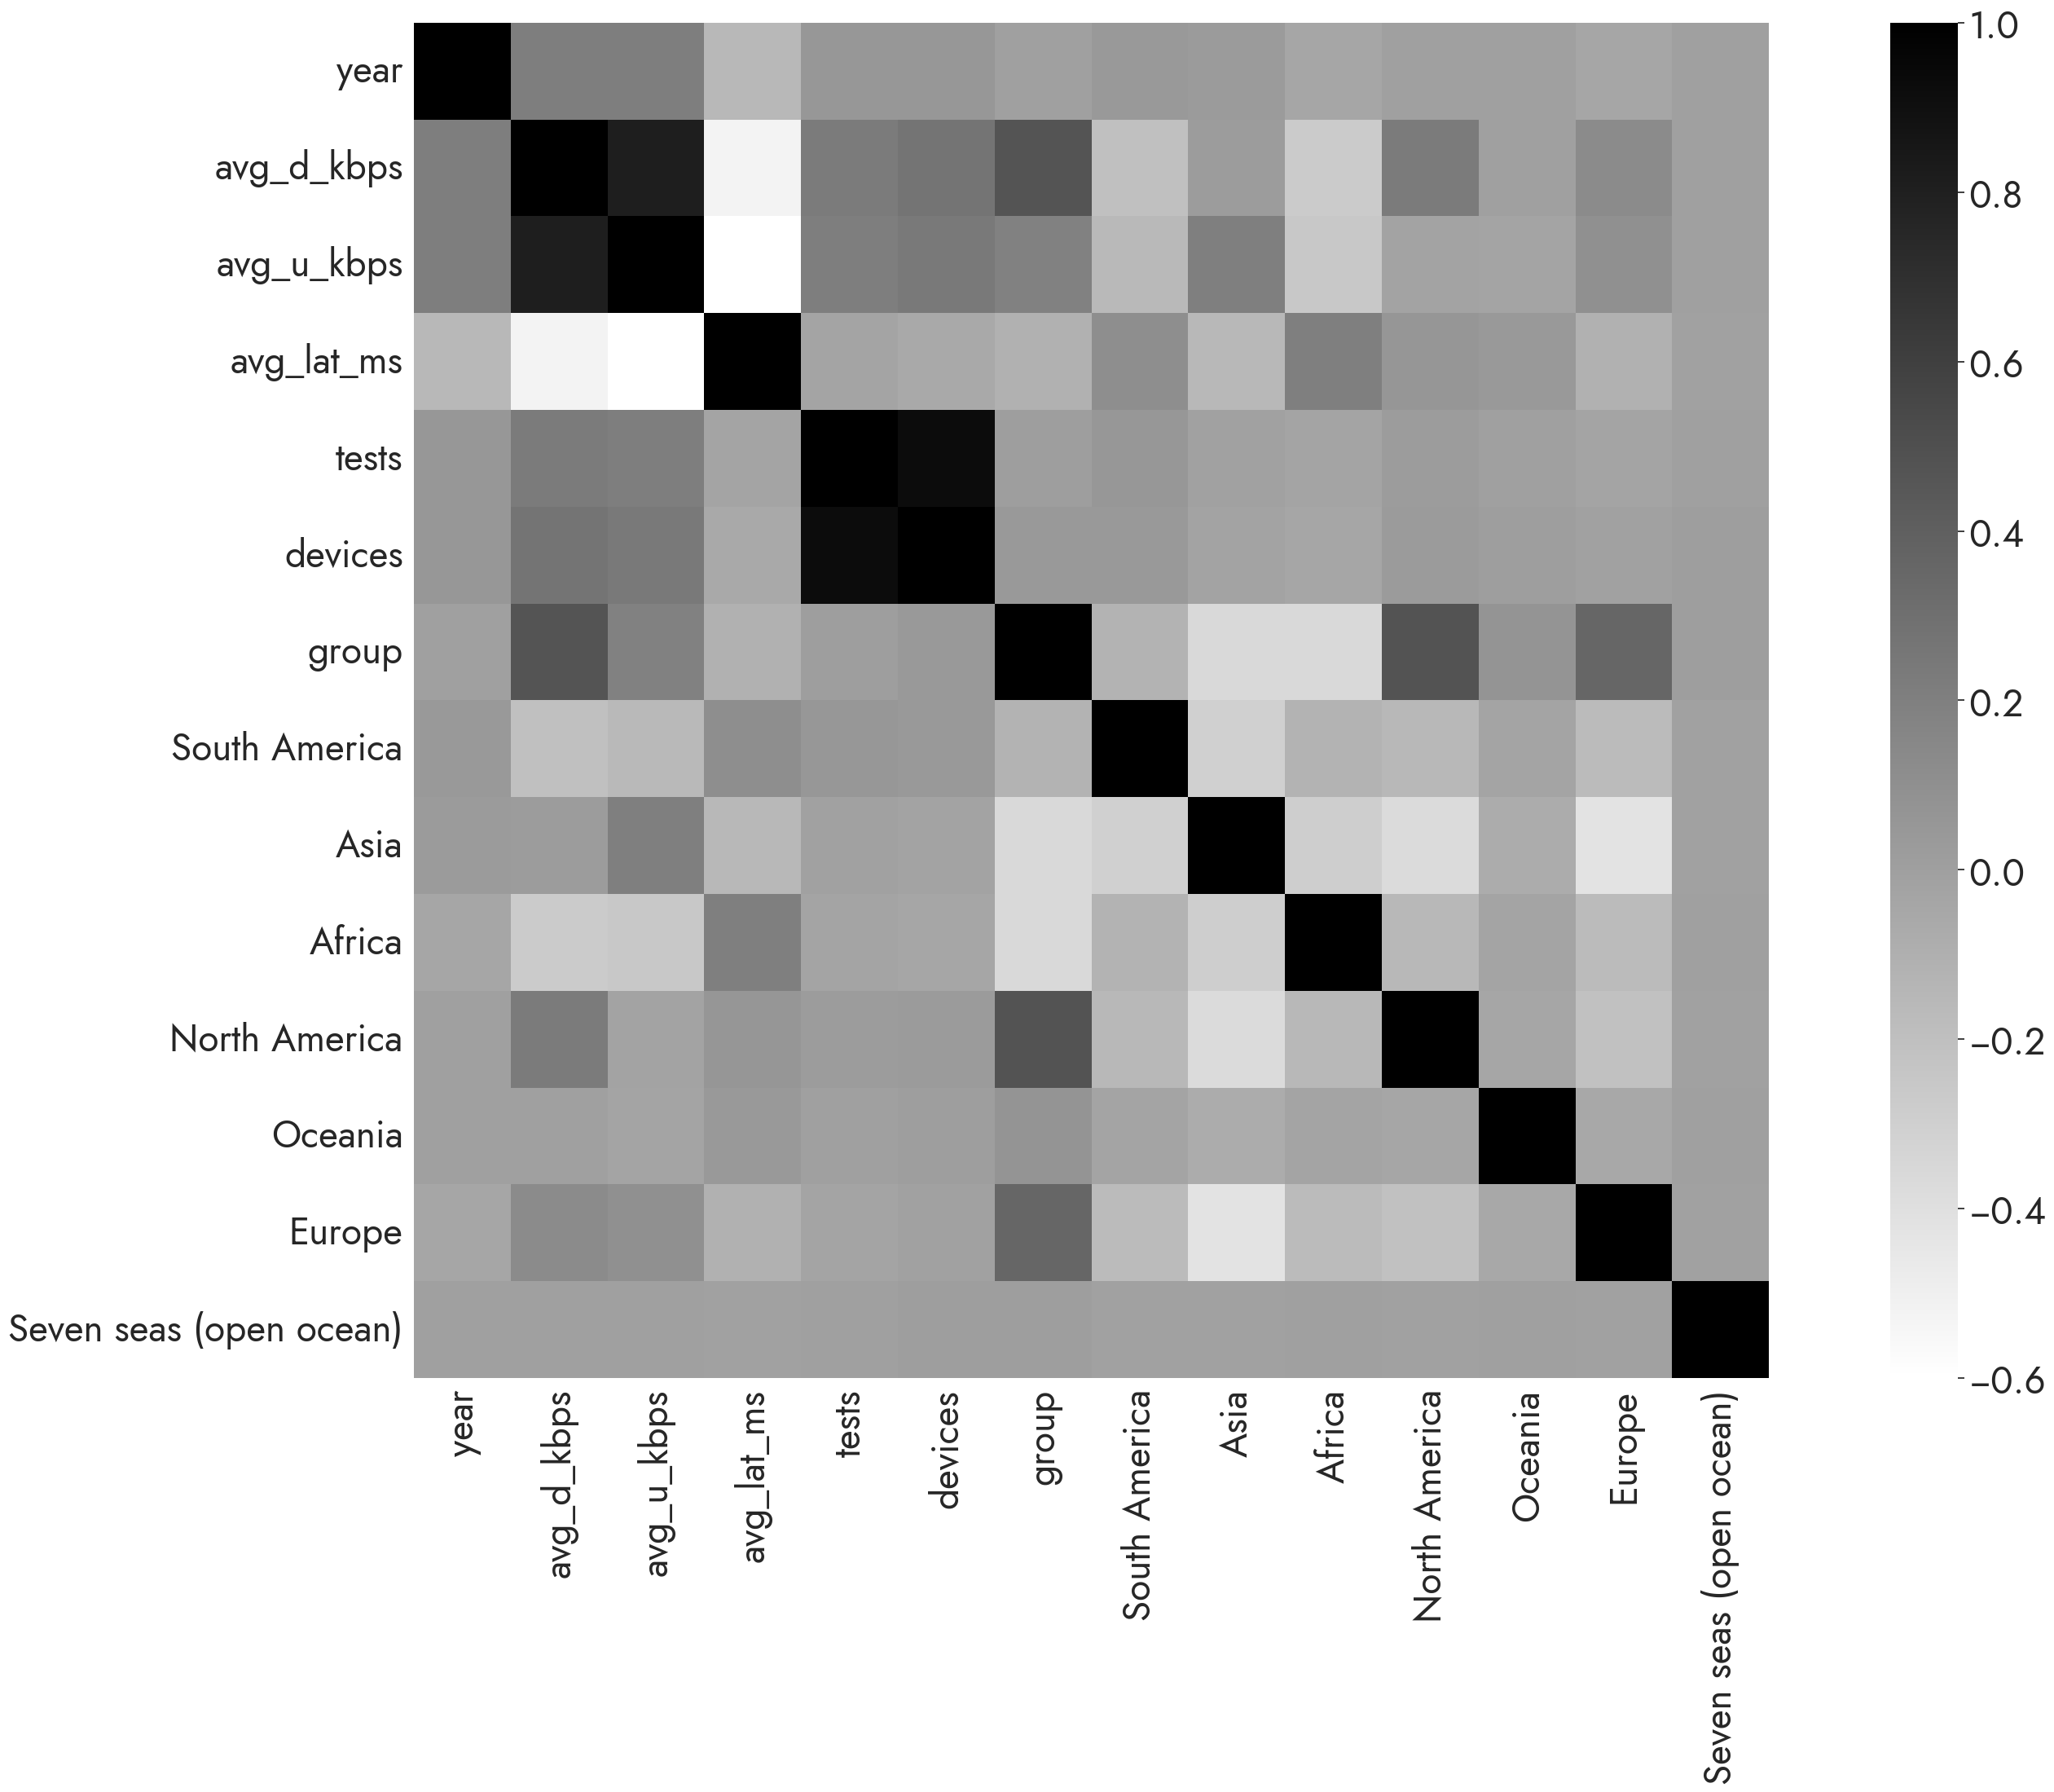

In [64]:
fixed_plot_correlation = sns.heatmap(fixed_correlation, cmap='gray_r', square=True);

In [65]:
fixed_plot_correlation.figure.savefig(f'{VISUAL_PATH}/fixed_correlation.png', transparent=True)

Разделим датасет на обучающий набор - 80%, и на тестовый - 20%

In [10]:
train_df = df.sample(frac=0.8, random_state=SEED)
test_df = df.drop(train_df.index)

print(len(train_df), 'training examples')
print(len(test_df), 'testing examples')

640000 training examples
160000 testing examples


Выделим целевой признак и преобразуем его в бинарную dummy-переменную

In [11]:
train_features = train_df
train_target = tf.keras.utils.to_categorical(train_features.pop('group'), dtype='int8')

In [12]:
test_features = test_df
test_target = tf.keras.utils.to_categorical(test_features.pop('group'), dtype='int8')

Из ноутбука с визуализацией было выяснено, что признаки выраженное левостороннее распределение.
Создадим слой для их нормализации и подгоним его состояние предварительной обработки к признакам

In [13]:
normalize = tf.keras.layers.Normalization()
normalize.adapt(train_features, batch_size=BATCH_SIZE)

2023-05-13 15:54:56.858635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-13 15:54:56.907682: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-13 15:54:56.907756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-13 15:54:56.909502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-13 15:54:56.909560: I tensorflow/compile

## Регрессия с глубокой нейронной сетью (DNN)
Регрессия с использованием DNN и нескольких входных данных

### Настройка модели
Зададим параметры обучения модели

В дальнейшем предполагается построение нескольких моделей, различающихся по крупности.
Напишем общую функцию их настройки и обучения:
* optimizer - формула, по которой происходит оптимизация модели
* loss - формула, по которой рассчитываются ошибки предсказаний модели
* batch_size - размер совокупности наблюдений, по которым модель обучается за раз
* callbacks - дополнительные параметры, в данном случае отвечающие за остановку обучения в случае минимальных изменений от эпохи, а также за запись процесса обучения

In [14]:
def compile_and_fit(model: tf.keras.Sequential, max_epochs: int = 100):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name='accuracy')
        ],
    )

    model.summary()

    history = model.fit(
        train_features, train_target,
        batch_size=BATCH_SIZE,
        validation_split=0.2,  # 20% of train data will validate model
        epochs=max_epochs,  # amount model trains
        verbose=2,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, start_from_epoch=10),
            tf.keras.callbacks.TensorBoard(f'{LOGS_PATH}/{model.name}'),
        ],
    )

    return history.history

### Обучение моделей
Создадим переменную, в которой будут сохранятся логи обучения моделей

In [15]:
size_histories = {}

#### Tiny
Начнём с самой маленькой модели, состоящей из двух обучающих слоёв

In [16]:
tiny_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(16, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='tiny'
)

In [17]:
size_histories['tiny'] = compile_and_fit(tiny_model)

Model: "tiny"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense (Dense)               (None, 16)                224       
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 319
Trainable params: 292
Non-trainable params: 27
_________________________________________________________________
Epoch 1/100


2023-05-13 15:55:11.659699: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0xfc44d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-13 15:55:11.659741: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-05-13 15:55:11.667270: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-13 15:55:13.024279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-05-13 15:55:13.177735: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8000/8000 - 31s - loss: 0.8230 - accuracy: 0.6379 - val_loss: 0.7762 - val_accuracy: 0.6592 - 31s/epoch - 4ms/step
Epoch 2/100
8000/8000 - 31s - loss: 0.7662 - accuracy: 0.6672 - val_loss: 0.7560 - val_accuracy: 0.6721 - 31s/epoch - 4ms/step
Epoch 3/100
8000/8000 - 31s - loss: 0.7536 - accuracy: 0.6756 - val_loss: 0.7485 - val_accuracy: 0.6793 - 31s/epoch - 4ms/step
Epoch 4/100
8000/8000 - 31s - loss: 0.7480 - accuracy: 0.6784 - val_loss: 0.7439 - val_accuracy: 0.6802 - 31s/epoch - 4ms/step
Epoch 5/100
8000/8000 - 31s - loss: 0.7449 - accuracy: 0.6800 - val_loss: 0.7411 - val_accuracy: 0.6799 - 31s/epoch - 4ms/step
Epoch 6/100
8000/8000 - 30s - loss: 0.7421 - accuracy: 0.6809 - val_loss: 0.7400 - val_accuracy: 0.6793 - 30s/epoch - 4ms/step
Epoch 7/100
8000/8000 - 30s - loss: 0.7405 - accuracy: 0.6808 - val_loss: 0.7391 - val_accuracy: 0.6810 - 30s/epoch - 4ms/step
Epoch 8/100
8000/8000 - 31s - loss: 0.7391 - accuracy: 0.6814 - val_loss: 0.7392 - val_accuracy: 0.6814 - 31s/epoch - 4ms/s

Визуализируем ход обучения

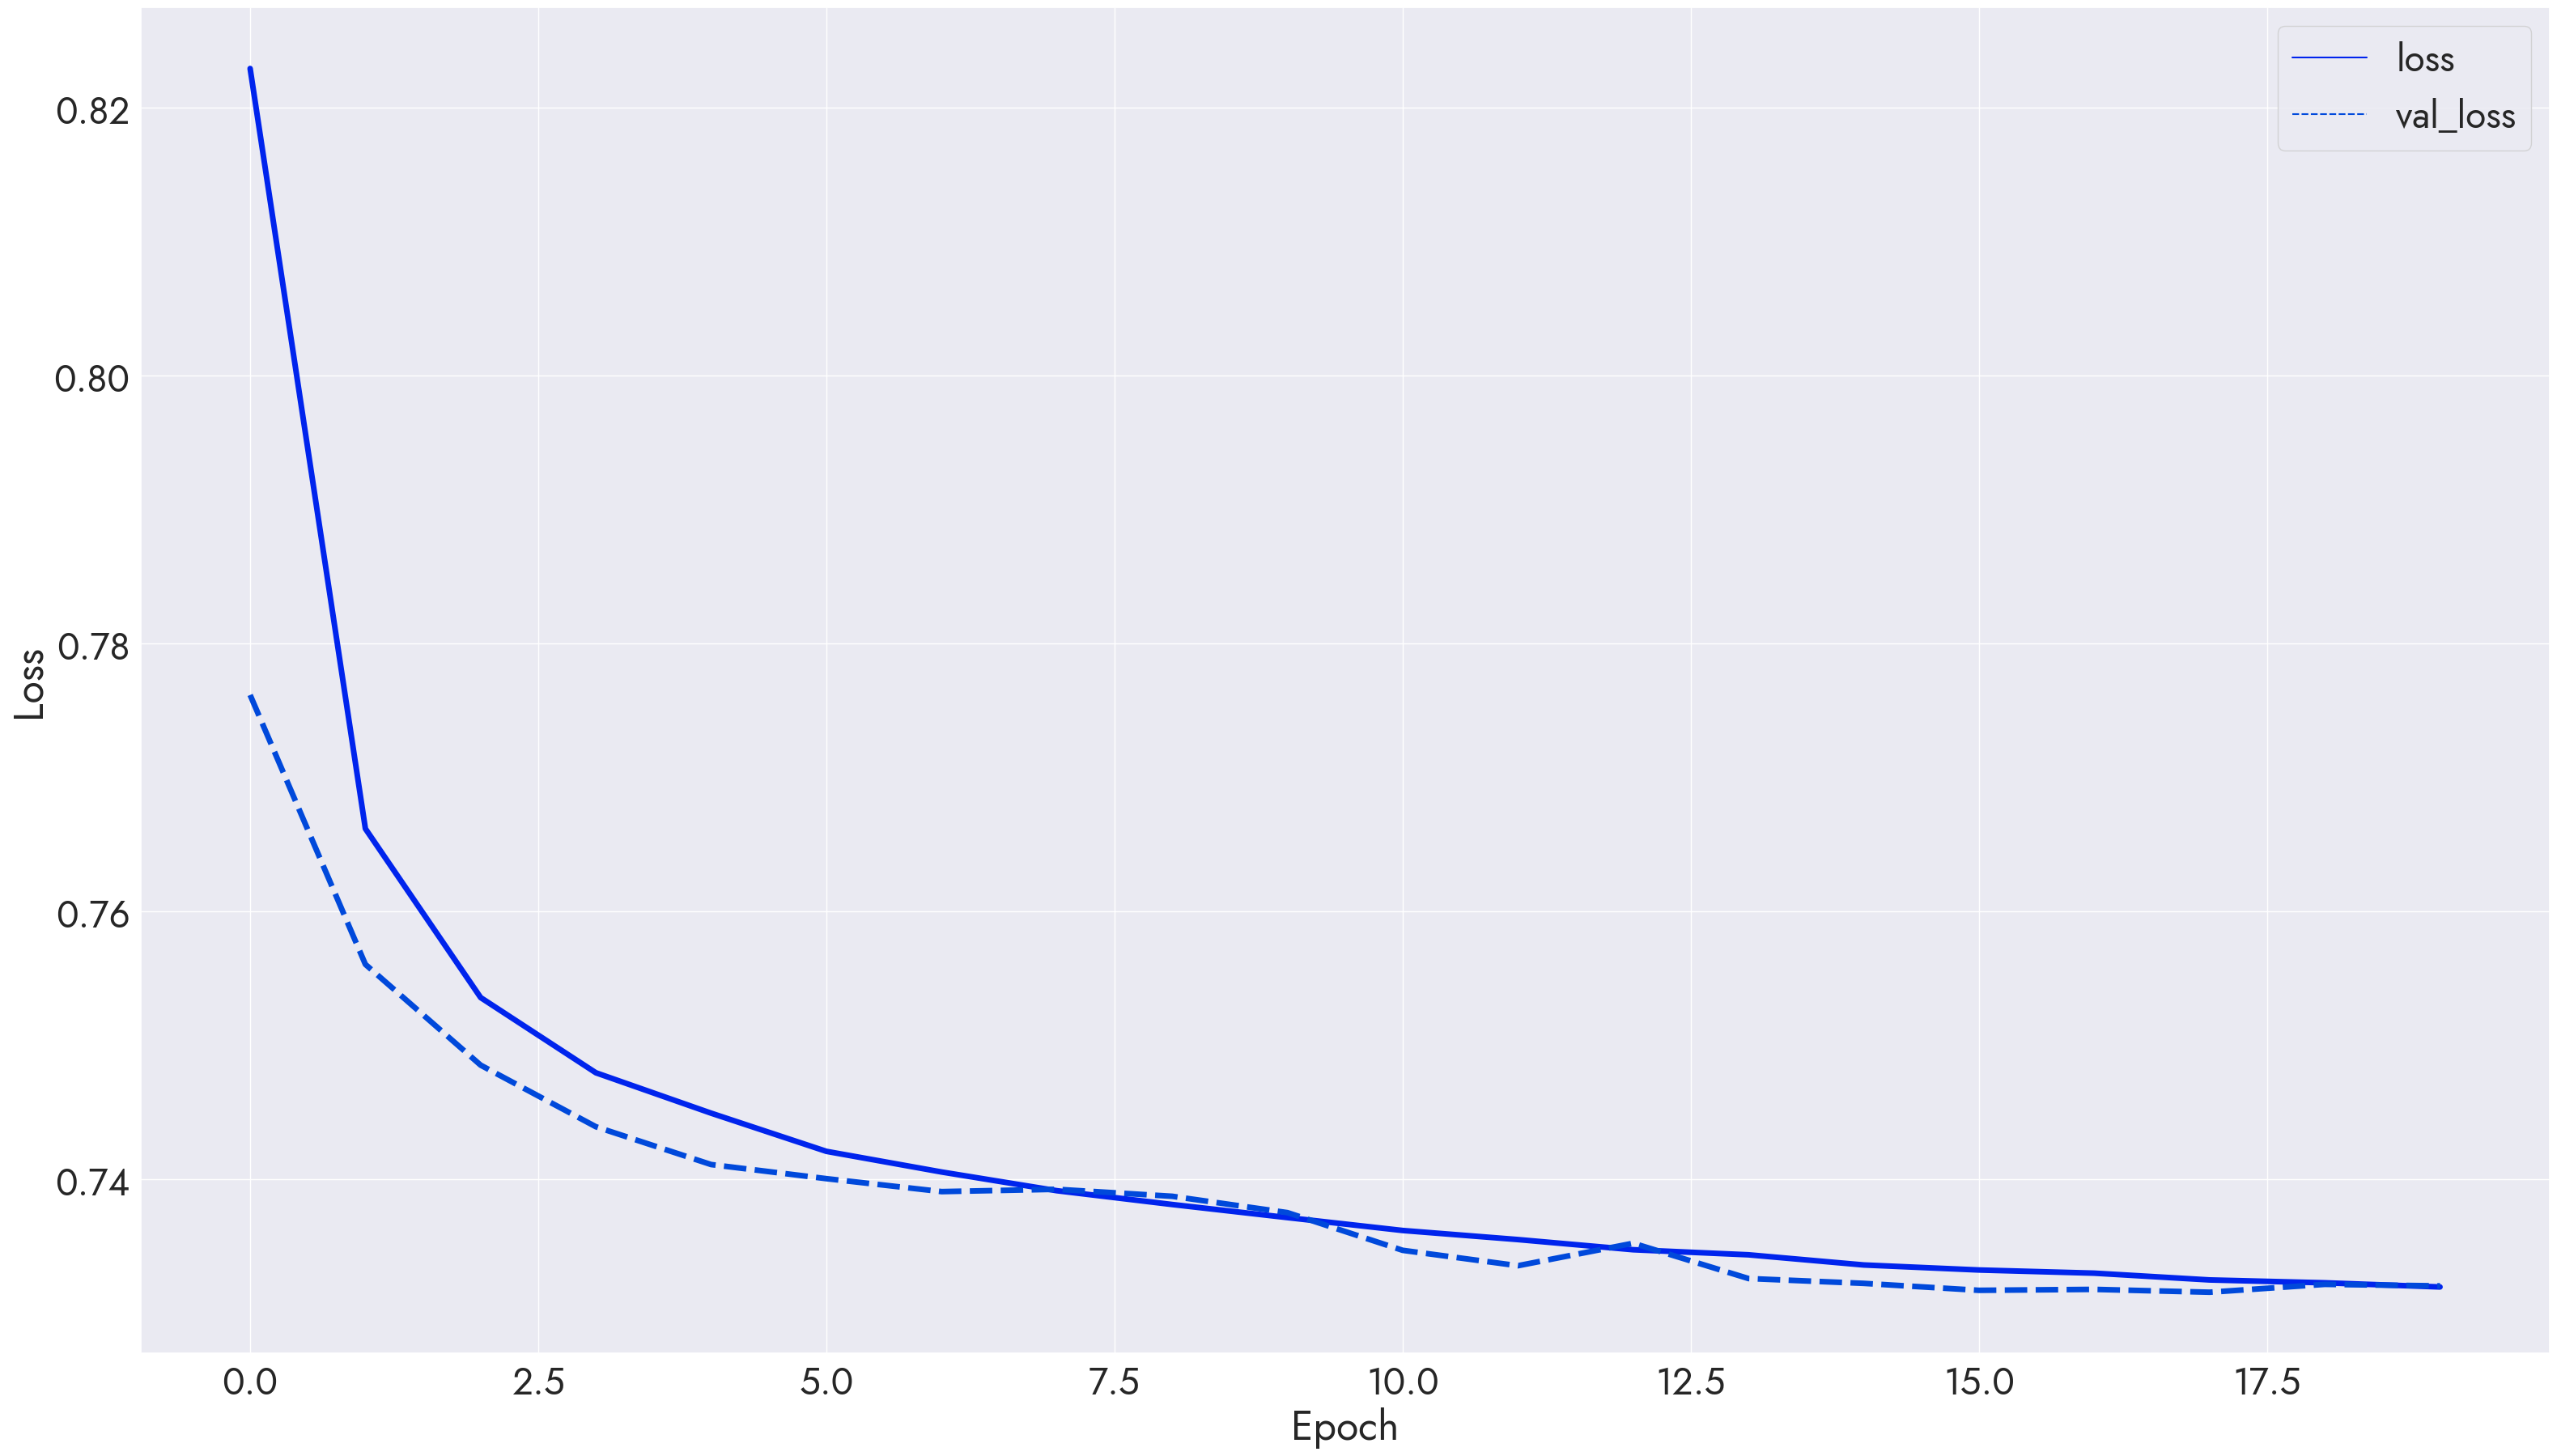

In [18]:
tiny_plot_history = sns.lineplot(data=pd.DataFrame(size_histories['tiny'])[['loss', 'val_loss']], linewidth=5)

tiny_plot_history.set_xlabel('Epoch')
tiny_plot_history.set_ylabel('Loss');

In [19]:
tiny_plot_history.figure.savefig(f'{VISUAL_PATH}/fixed_tiny_history.png', transparent=True)

Посмотрим предсказательные возможности модели

In [20]:
tiny_evaluation = tiny_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2)
print(f'Accuracy: {tiny_evaluation[1]}')

10000/10000 - 27s - loss: 0.7323 - accuracy: 0.6817 - 27s/epoch - 3ms/step
Accuracy: 0.6816703081130981


In [21]:
tiny_evaluation = tiny_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2)
print(f'Accuracy: {tiny_evaluation[1]}')

2500/2500 - 7s - loss: 0.7310 - accuracy: 0.6836 - 7s/epoch - 3ms/step
Accuracy: 0.6836125254631042


Сохраним модель для возможности её использования в будущем

In [22]:
tiny_model.save(f'{MODEL_PATH}/fixed_tiny')

INFO:tensorflow:Assets written to: model/merged/fixed_tiny/assets


#### Small

In [23]:
small_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(16, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(16, activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='small'
)

In [24]:
size_histories['small'] = compile_and_fit(small_model)

Model: "small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense_2 (Dense)             (None, 16)                224       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 4)                 68        
                                                                 
Total params: 591
Trainable params: 564
Non-trainable params: 27
______________________________________________________________

Визуализируем ход обучения

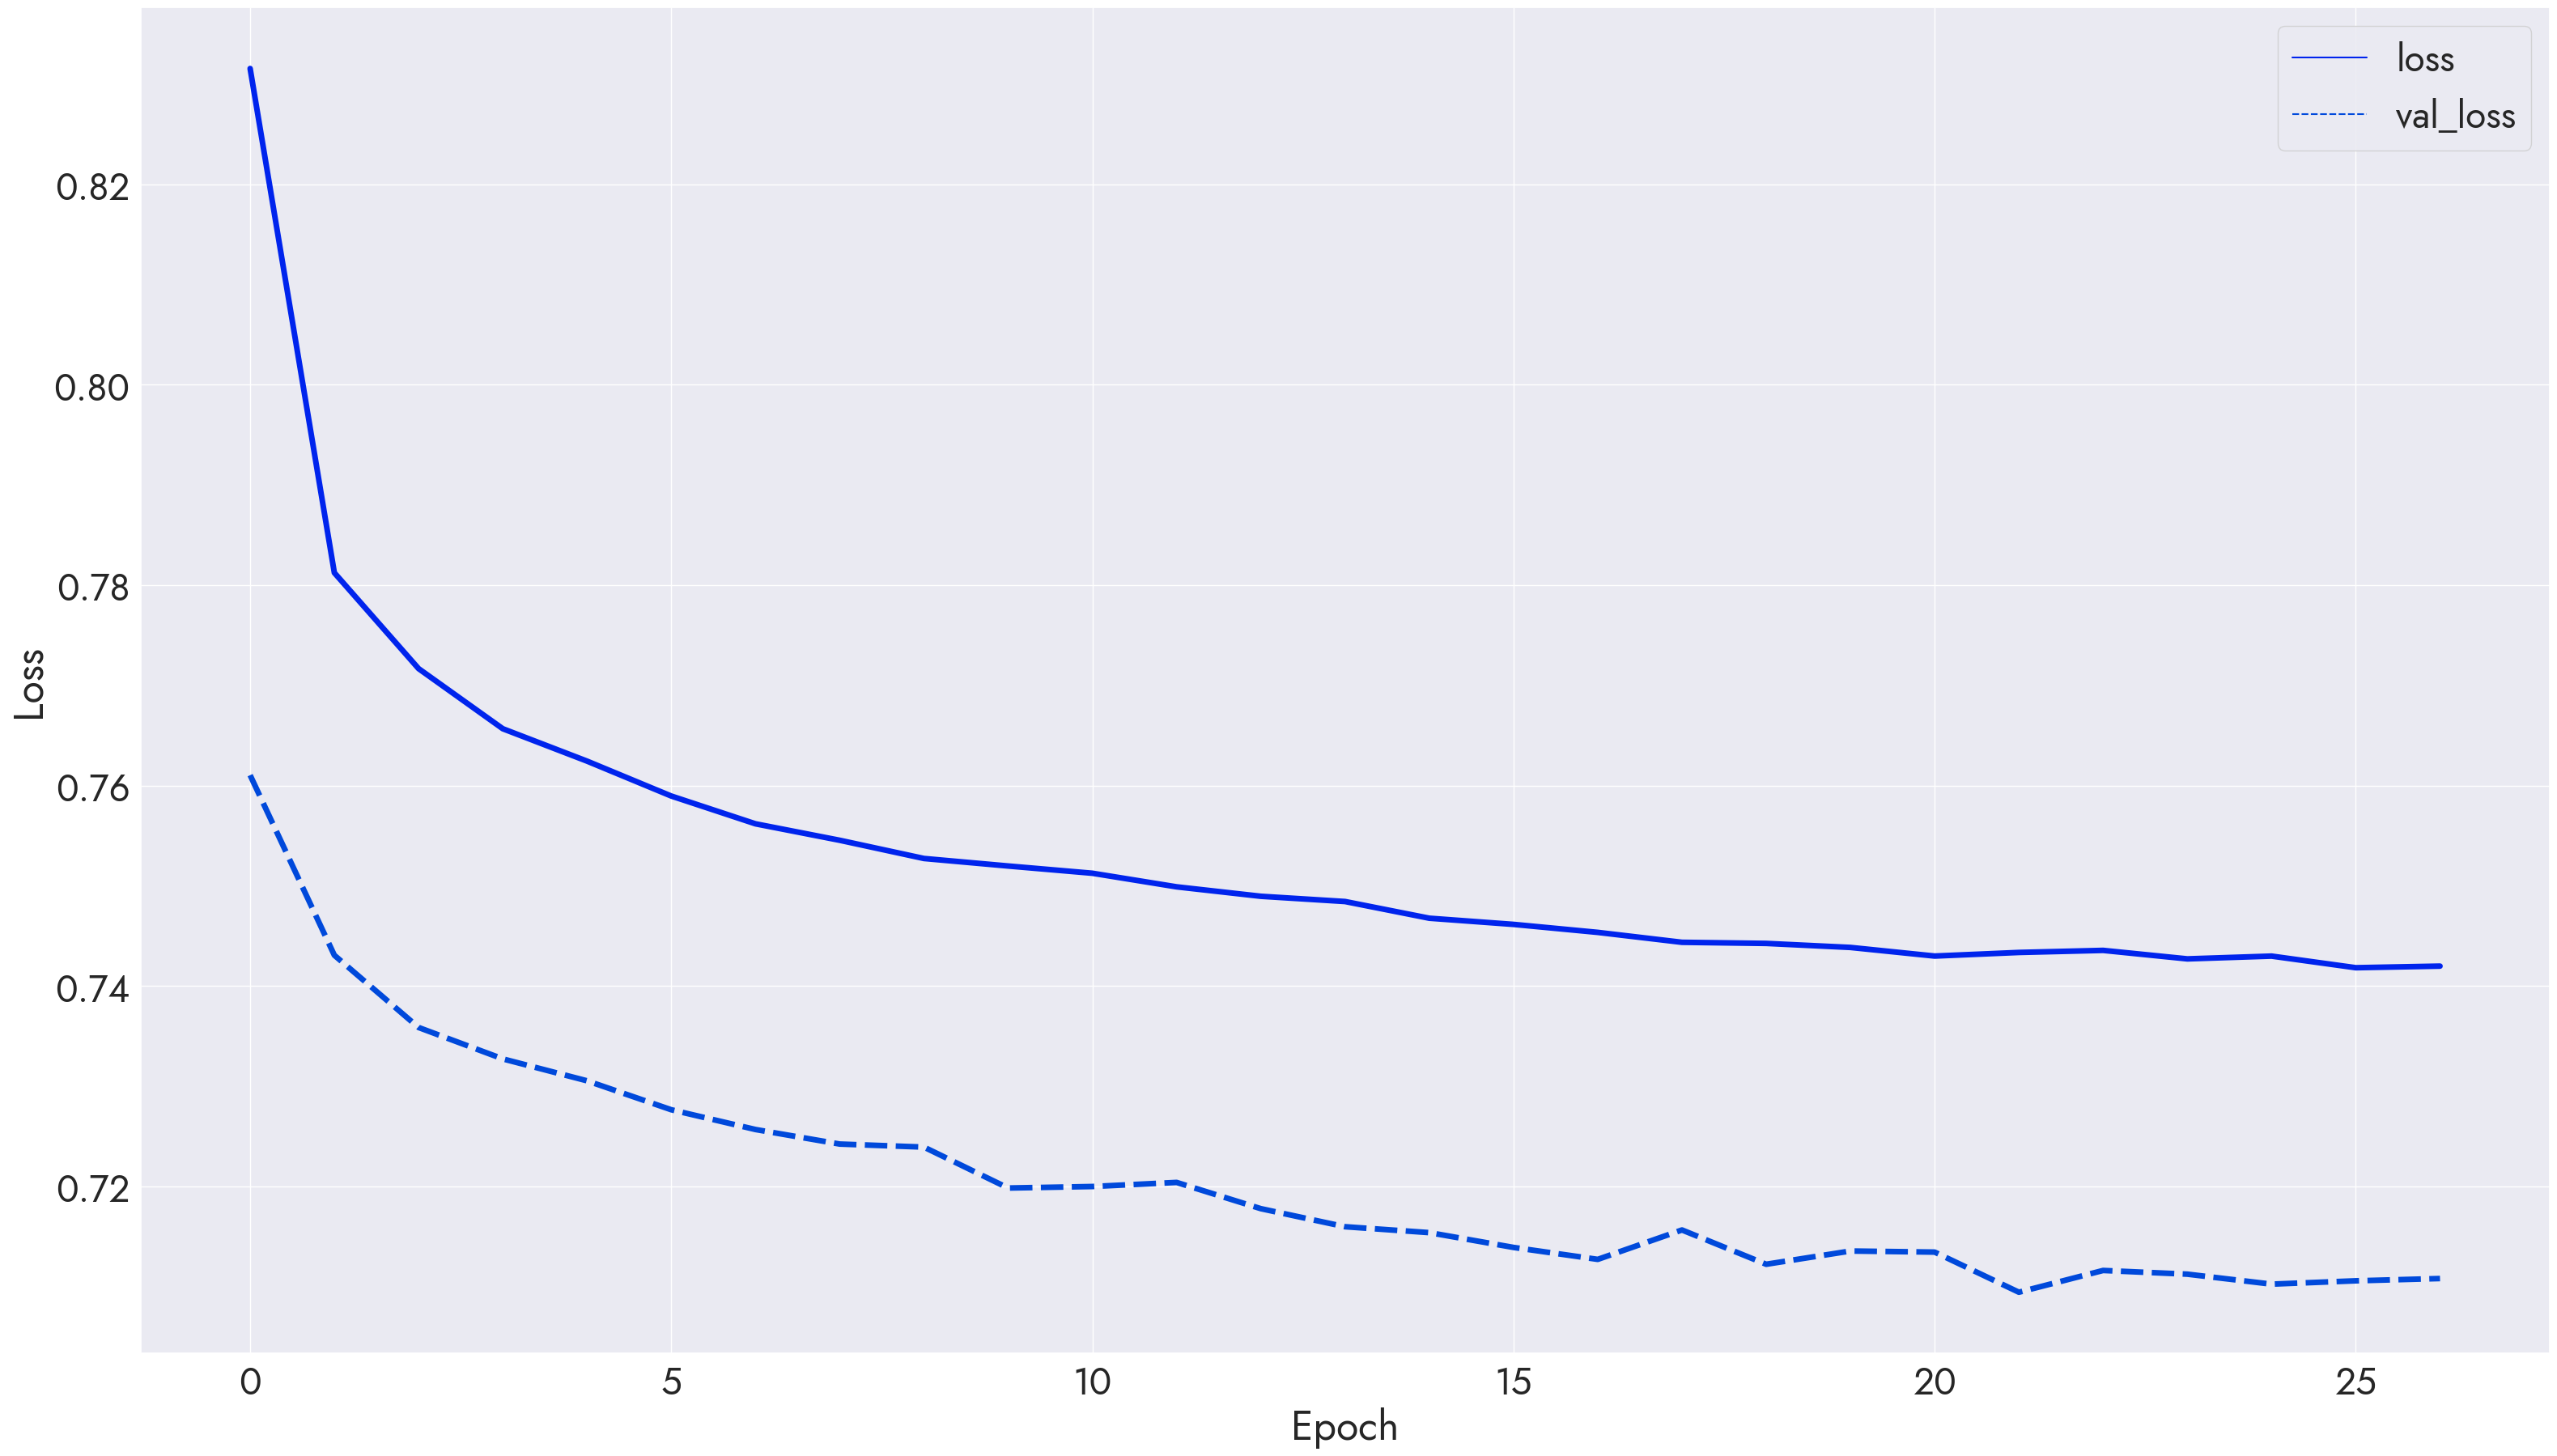

In [25]:
small_plot_history = sns.lineplot(data=pd.DataFrame(size_histories['small'])[['loss', 'val_loss']], linewidth=5)

small_plot_history.set_xlabel('Epoch')
small_plot_history.set_ylabel('Loss');

In [26]:
small_plot_history.figure.savefig(f'{VISUAL_PATH}/fixed_small_history.png', transparent=True)

Посмотрим предсказательные возможности модели

In [27]:
small_evaluation = small_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2)
print(f'Accuracy: {small_evaluation[1]}')

10000/10000 - 28s - loss: 0.7111 - accuracy: 0.6873 - 28s/epoch - 3ms/step
Accuracy: 0.6872546672821045


In [28]:
small_evaluation = small_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2)
print(f'Accuracy: {small_evaluation[1]}')

2500/2500 - 7s - loss: 0.7115 - accuracy: 0.6884 - 7s/epoch - 3ms/step
Accuracy: 0.6884437203407288


Сохраним модель для возможности её использования в будущем

In [29]:
small_model.save(f'{MODEL_PATH}/fixed_small')

2023-05-13 16:20:29.612006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16]
	 [[{{node inputs}}]]
2023-05-13 16:20:29.759942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: model/merged/fixed_small/assets


#### Medium

In [30]:
medium_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='medium'
)

In [31]:
size_histories['medium'] = compile_and_fit(medium_model)

Model: "medium"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                896       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                                 
Total params: 5,343
Trainable params: 5,316
Non-trainable params: 27
_________________________________________________________

Визуализируем ход обучения

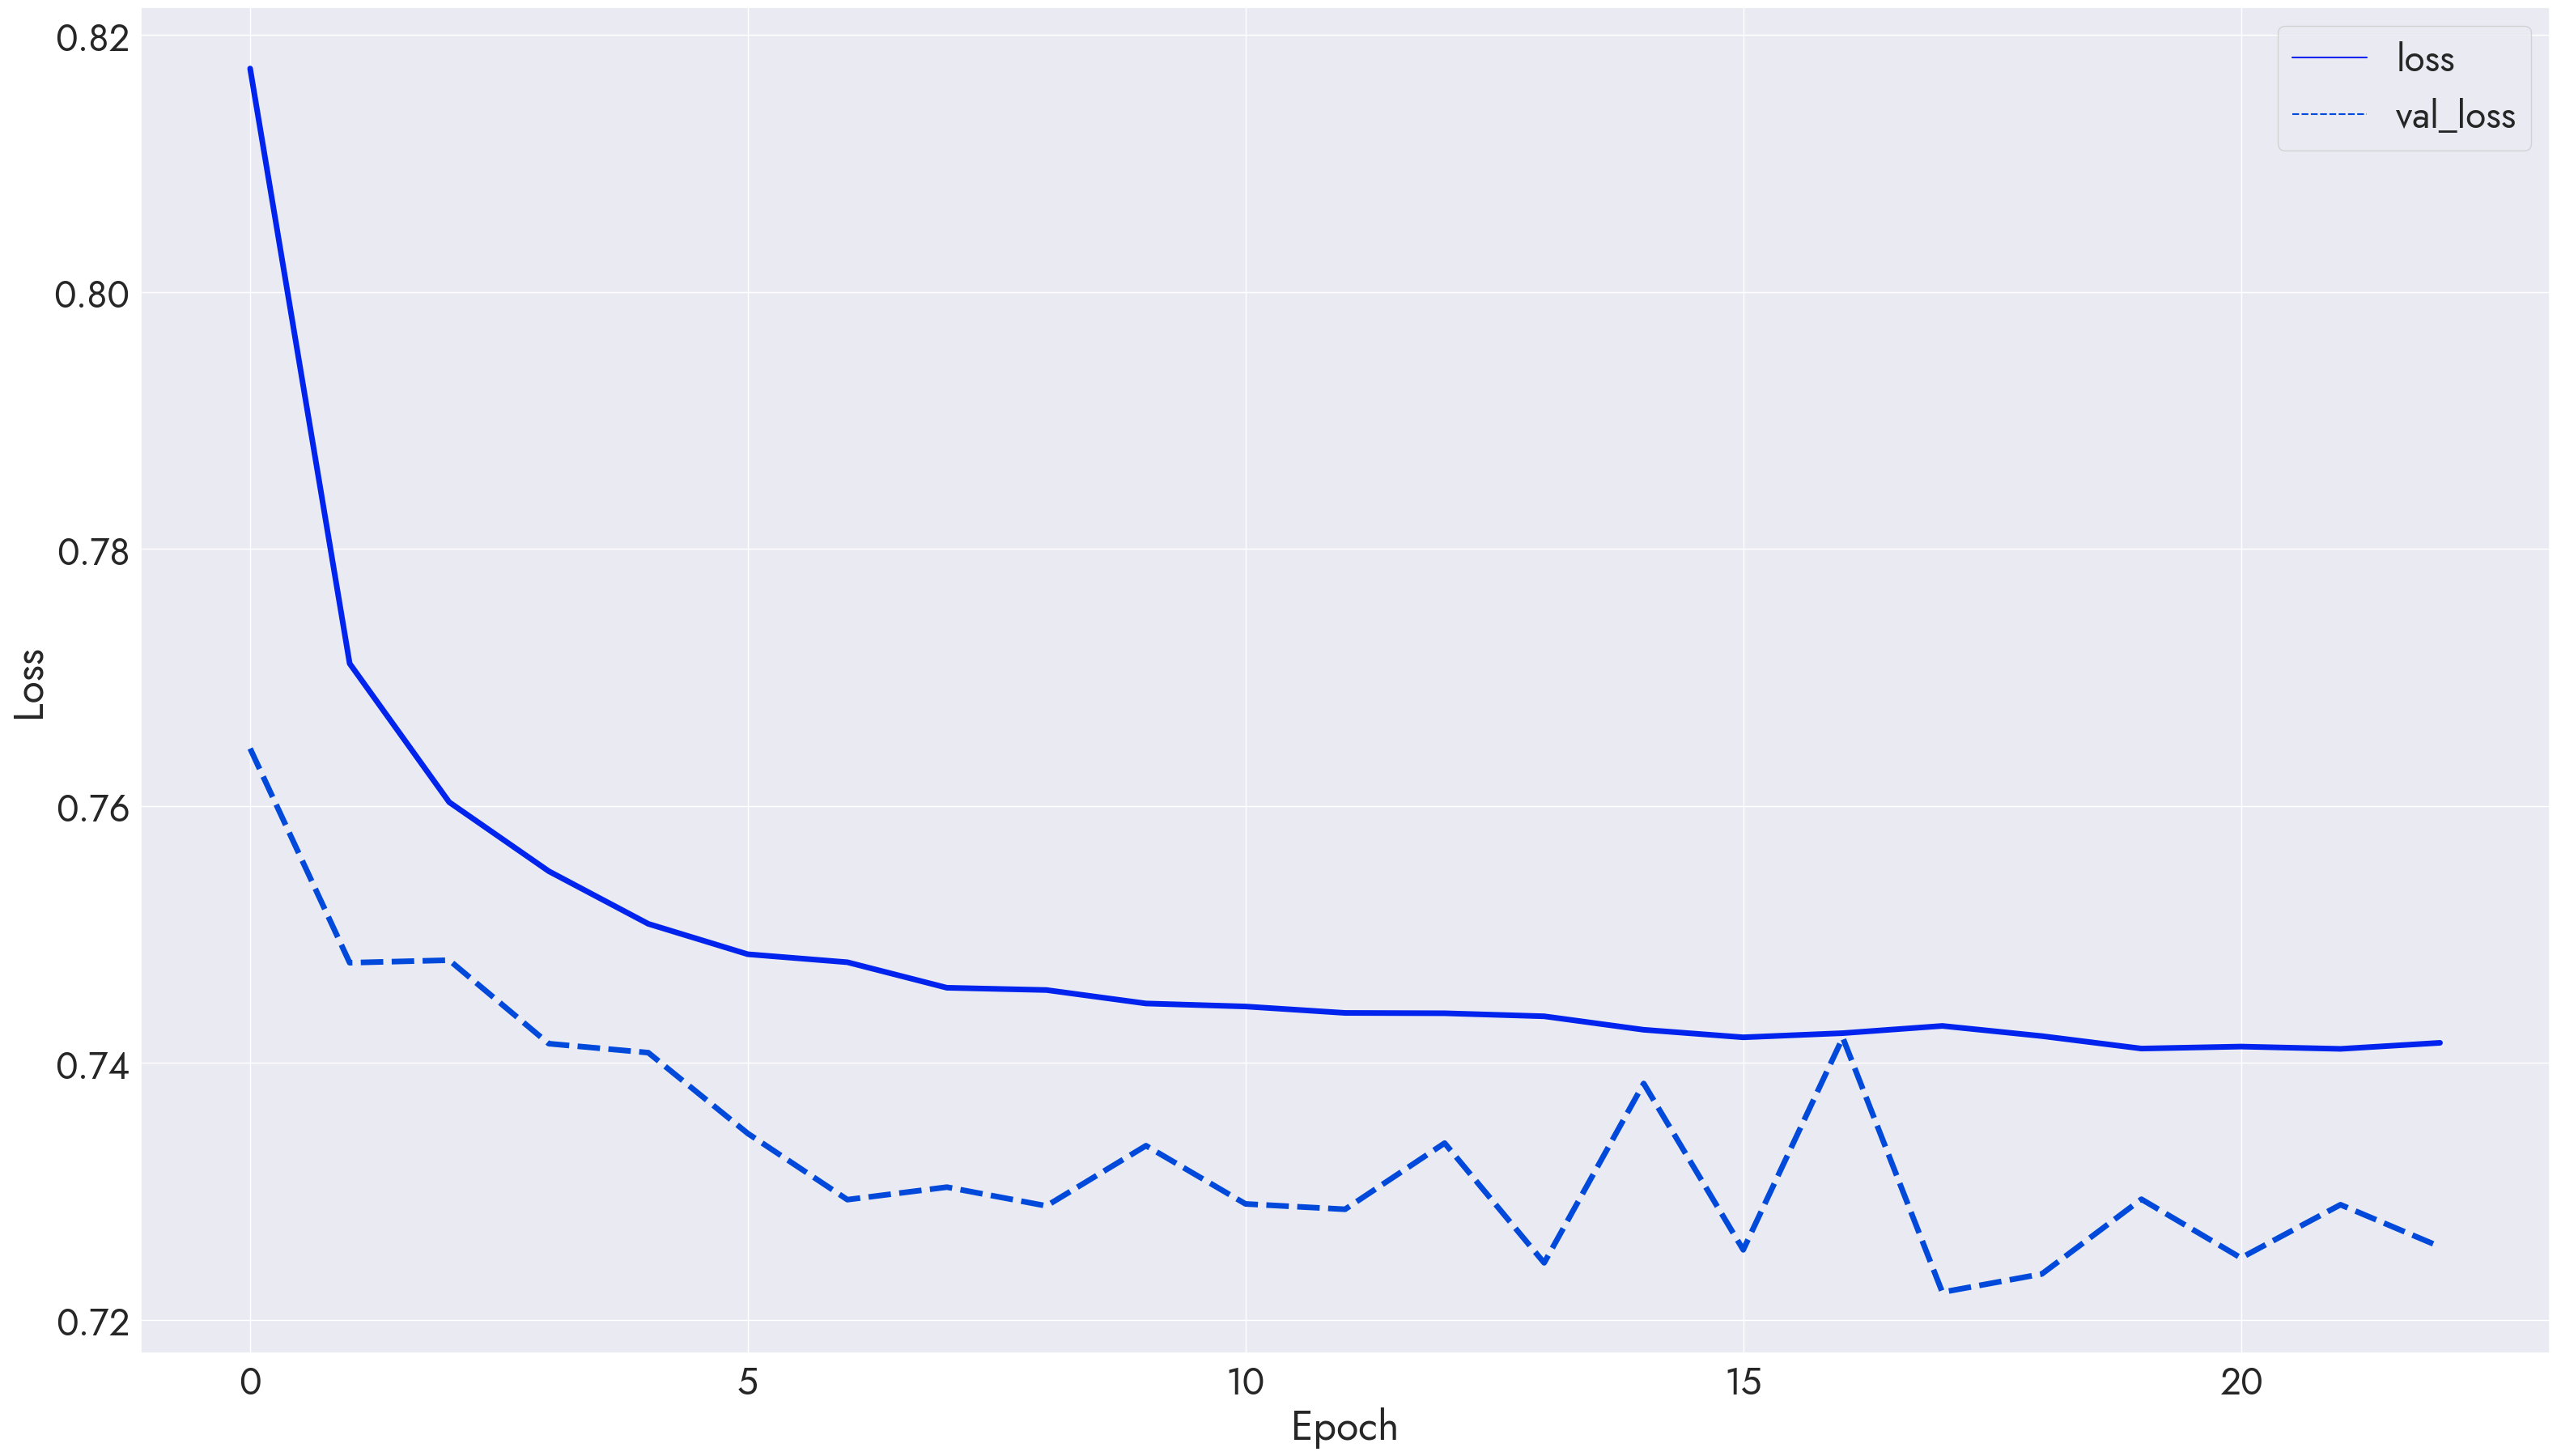

In [32]:
medium_plot_history = sns.lineplot(data=pd.DataFrame(size_histories['medium'])[['loss', 'val_loss']], linewidth=5)

medium_plot_history.set_xlabel('Epoch')
medium_plot_history.set_ylabel('Loss');

In [33]:
medium_plot_history.figure.savefig(f'{VISUAL_PATH}/fixed_medium_history.png', transparent=True)

Посмотрим предсказательные возможности модели

In [34]:
medium_evaluation = medium_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2)
print(f'Accuracy: {medium_evaluation[1]}')

10000/10000 - 27s - loss: 0.7261 - accuracy: 0.6873 - 27s/epoch - 3ms/step
Accuracy: 0.6872718930244446


In [35]:
medium_evaluation = medium_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2)
print(f'Accuracy: {medium_evaluation[1]}')

2500/2500 - 7s - loss: 0.7262 - accuracy: 0.6885 - 7s/epoch - 3ms/step
Accuracy: 0.6884750127792358


Сохраним модель для возможности её использования в будущем

In [36]:
medium_model.save(f'{MODEL_PATH}/fixed_medium')

2023-05-13 16:33:15.030949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-05-13 16:33:15.185893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: model/merged/fixed_medium/assets


#### Large

In [37]:
large_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='large'
)

In [38]:
size_histories['large'] = compile_and_fit(large_model)

Model: "large"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense_8 (Dense)             (None, 512)               7168      
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                32832     
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                             

Визуализируем ход обучения

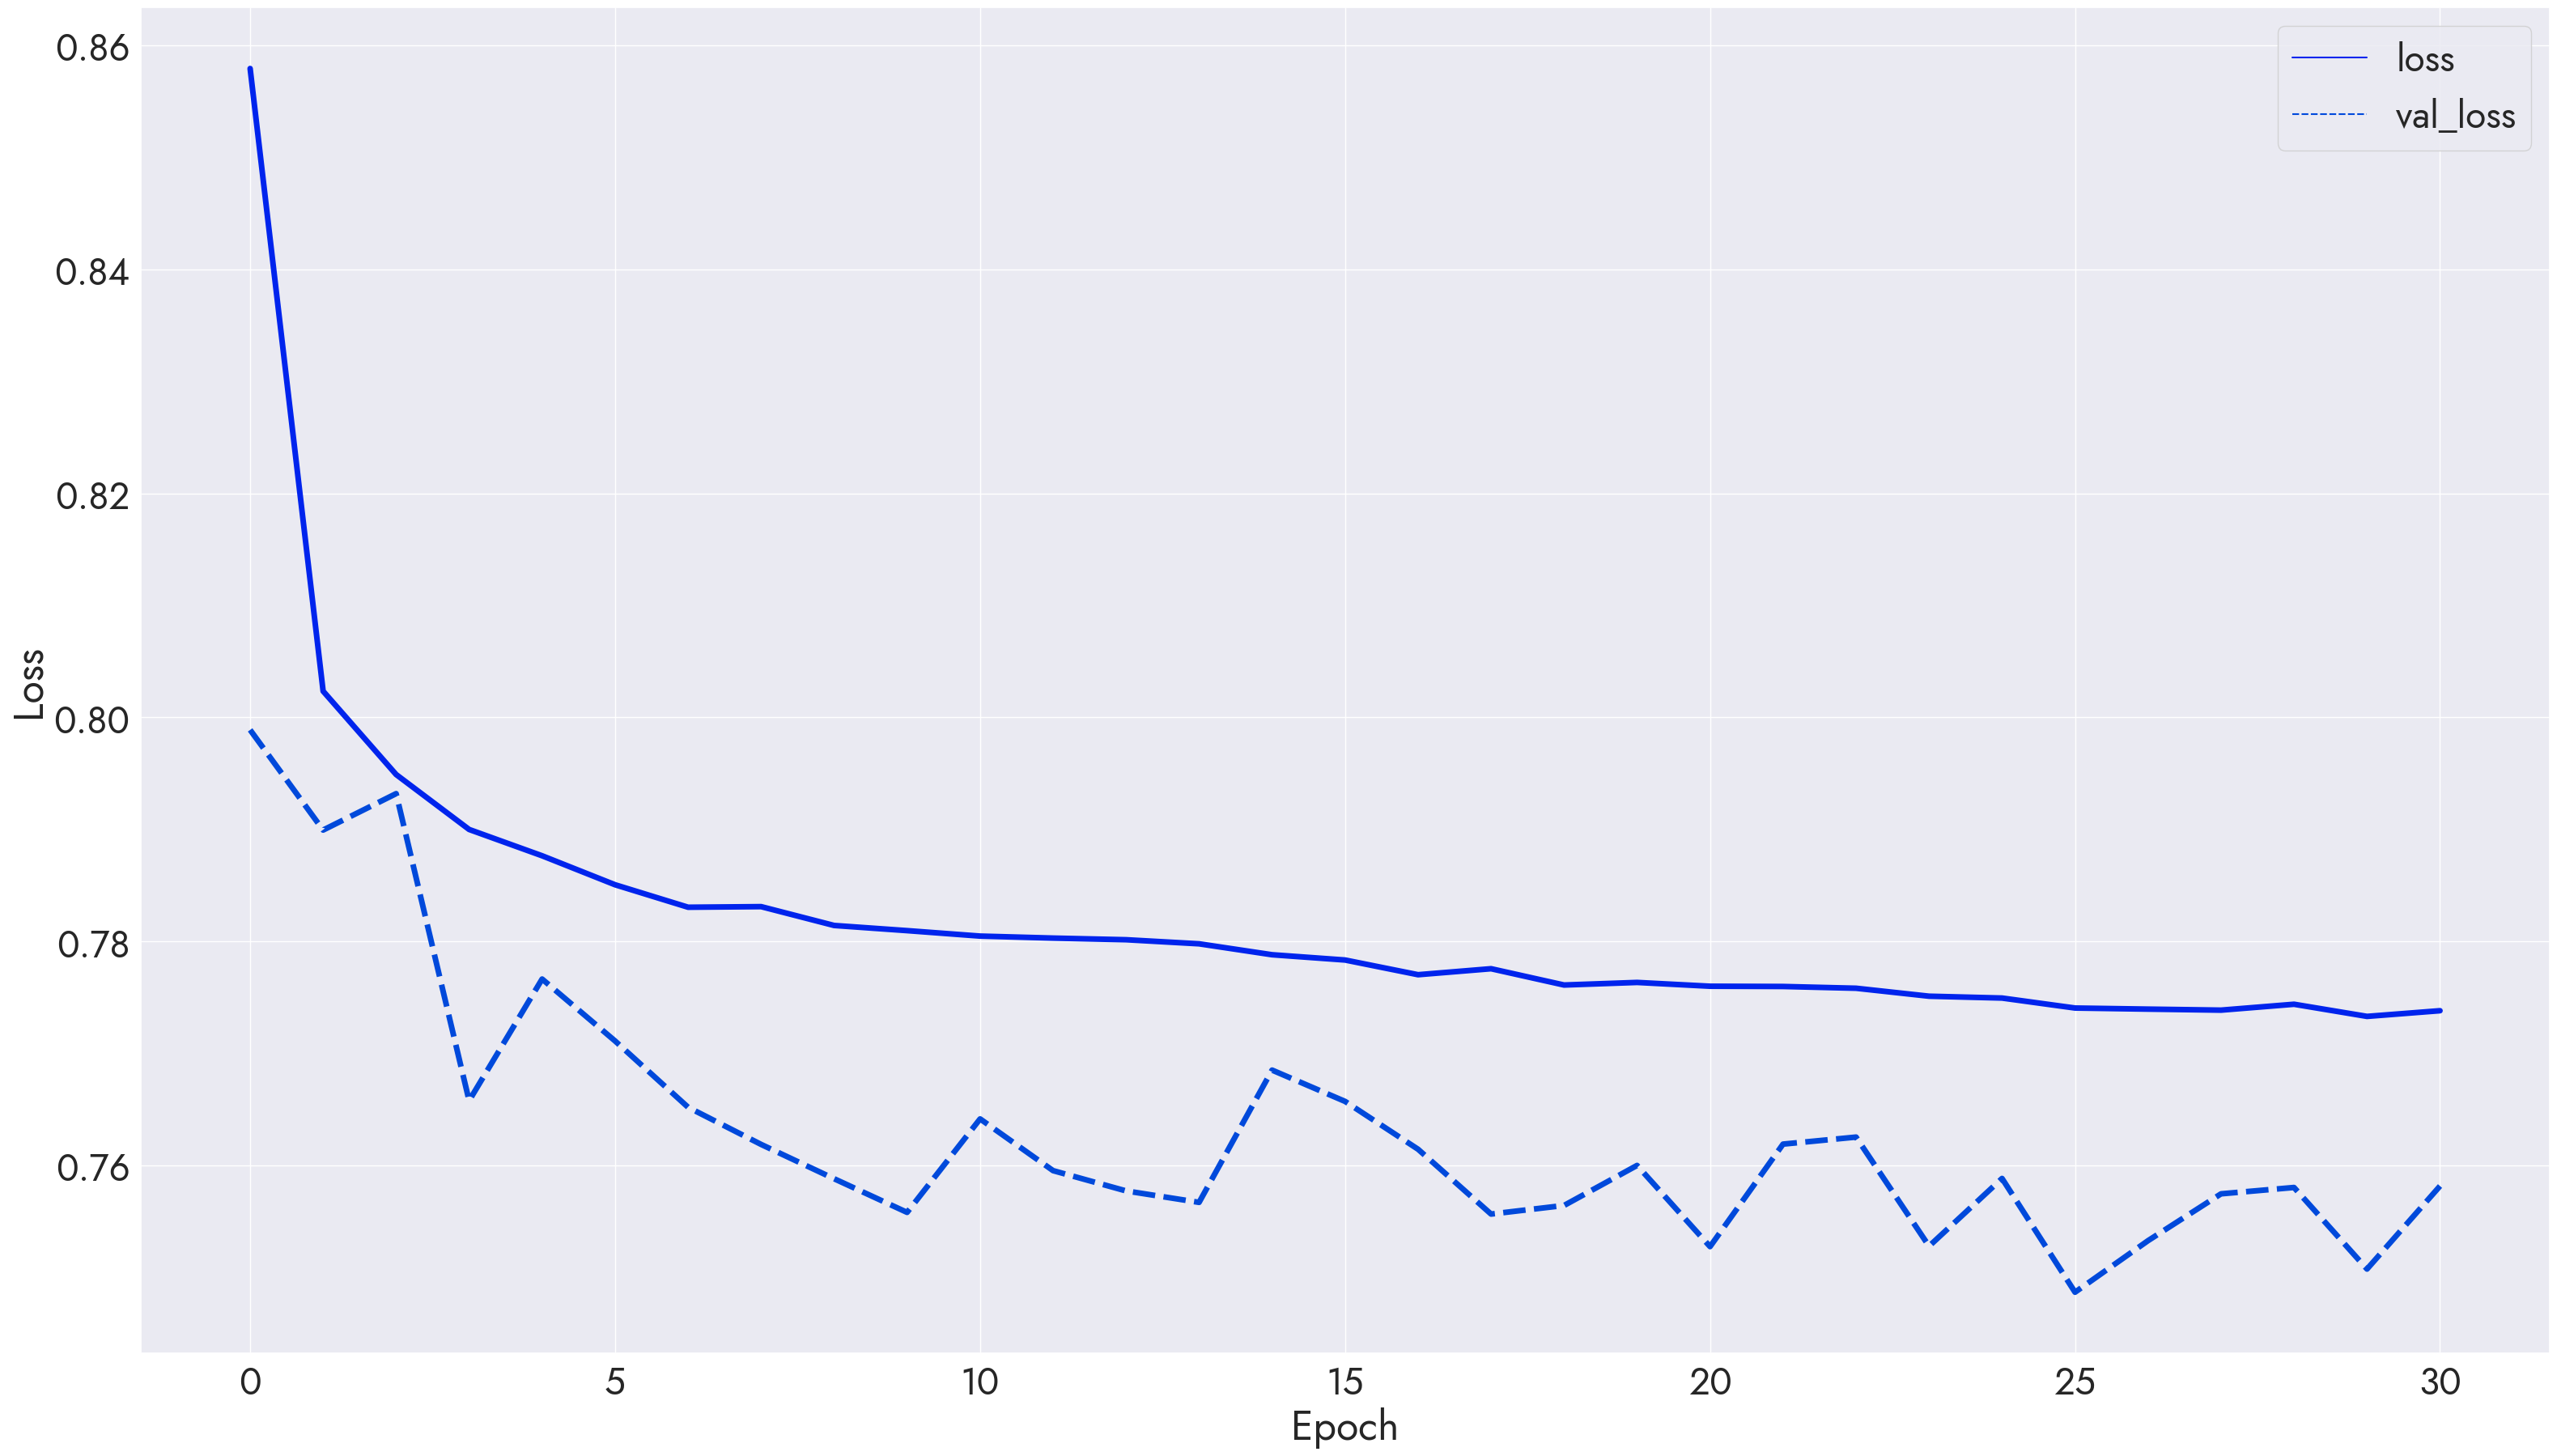

In [39]:
large_plot_history = sns.lineplot(data=pd.DataFrame(size_histories['large'])[['loss', 'val_loss']], linewidth=5)

large_plot_history.set_xlabel('Epoch')
large_plot_history.set_ylabel('Loss');

In [40]:
large_plot_history.figure.savefig(f'{VISUAL_PATH}/fixed_large_history.png', transparent=True)

Посмотрим предсказательные возможности модели

In [41]:
large_evaluation = large_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2)
print(f'Accuracy: {large_evaluation[1]}')

10000/10000 - 29s - loss: 0.7583 - accuracy: 0.6838 - 29s/epoch - 3ms/step
Accuracy: 0.6838359236717224


In [42]:
large_evaluation = large_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2)
print(f'Accuracy: {large_evaluation[1]}')

2500/2500 - 7s - loss: 0.7579 - accuracy: 0.6855 - 7s/epoch - 3ms/step
Accuracy: 0.68545001745224


Сохраним модель для возможности её использования в будущем

In [43]:
large_model.save(f'{MODEL_PATH}/fixed_large')

2023-05-13 16:56:10.542233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-05-13 16:56:10.560244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-05-13 16:56:10.770159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-05-13 16:56:

INFO:tensorflow:Assets written to: model/merged/fixed_large/assets


#### Итоговая модель
Визуализируем процесс расчёта точности предсказаний для каждой модели

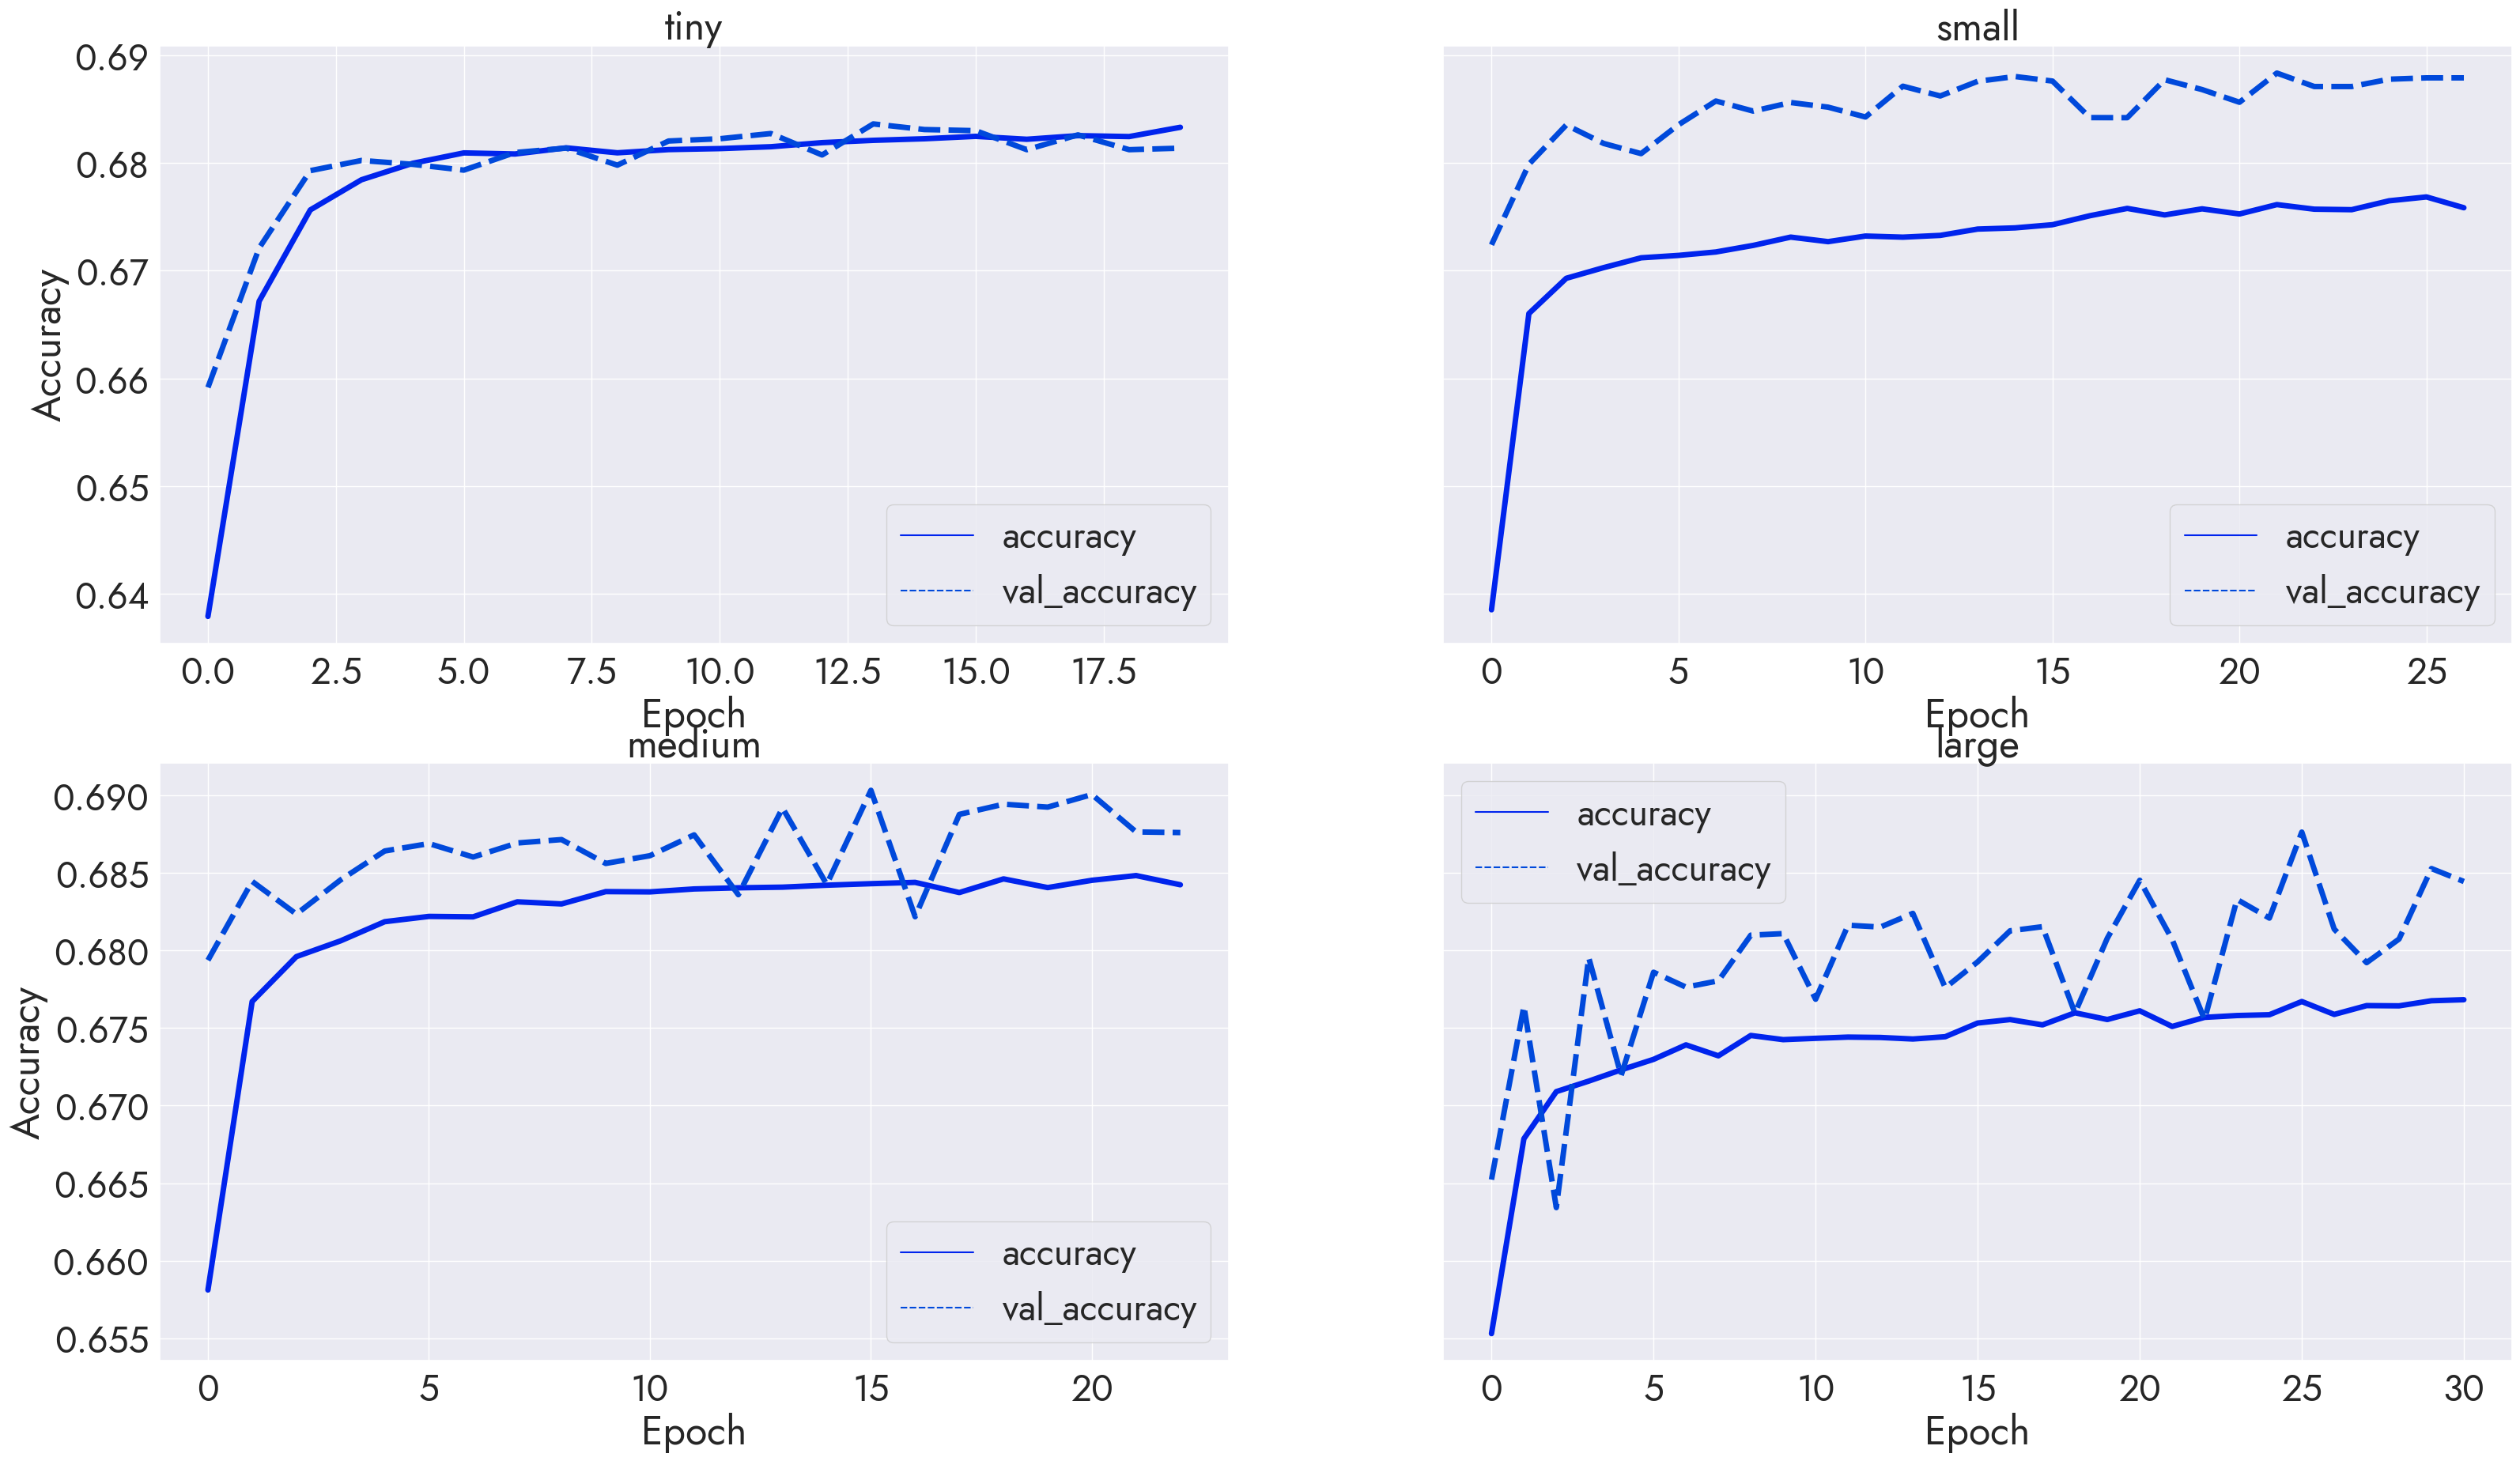

In [44]:
fig, axs = plt.subplots(2, 2, sharey='row')

for history_name, ax in zip(size_histories, axs.flat):
    sns.lineplot(data=pd.DataFrame(size_histories[history_name])[['accuracy', 'val_accuracy']], linewidth=5, ax=ax)

    ax.set_title(history_name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')

In [45]:
fig.savefig(f'{VISUAL_PATH}/fixed_history.png', transparent=True)

Выберем в качестве основной модель с наибольшей точностью предсказаний

In [46]:
fixed_model = medium_model

### Диаграммы
Визуализируем полученные результаты - начнём с определения предсказанных значений

In [47]:
test_predict = fixed_model.predict(test_features, batch_size=BATCH_SIZE, verbose=2);

2500/2500 - 4s - 4s/epoch - 1ms/step


Массив предсказанных значений состоит из весов, с каким шансом к какой группе относится конкретное наблюдение.
Конвертируем его в вид dummy-переменных

In [48]:
test_predict = np.where(test_predict == test_predict.max(axis=1).reshape(-1, 1), 1, 0).astype('int8')

Посмотрим распределение предсказаний модели по группам

In [49]:
fixed_distribution = (
    pd.pivot_table(
        data=pd.concat(
            [
                pd.from_dummies(pd.DataFrame(test_target)).rename(columns={'': 'target'}),
                pd.DataFrame(test_predict),
            ],
            axis=1
        ),
        columns='target',
        aggfunc='sum',
    )
    .rename(
        index=dict(zip(range(4), groups)),
        columns=dict(zip(range(4), groups)),
    )
)

fixed_distribution.head()

target,Low income,Lower-middle income,Upper-middle income,High income
Low income,29428,10110,3951,250
Lower-middle income,8541,20574,3904,871
Upper-middle income,1600,6672,24111,2747
High income,657,2641,7900,36043


Выведем это на тепловую карту

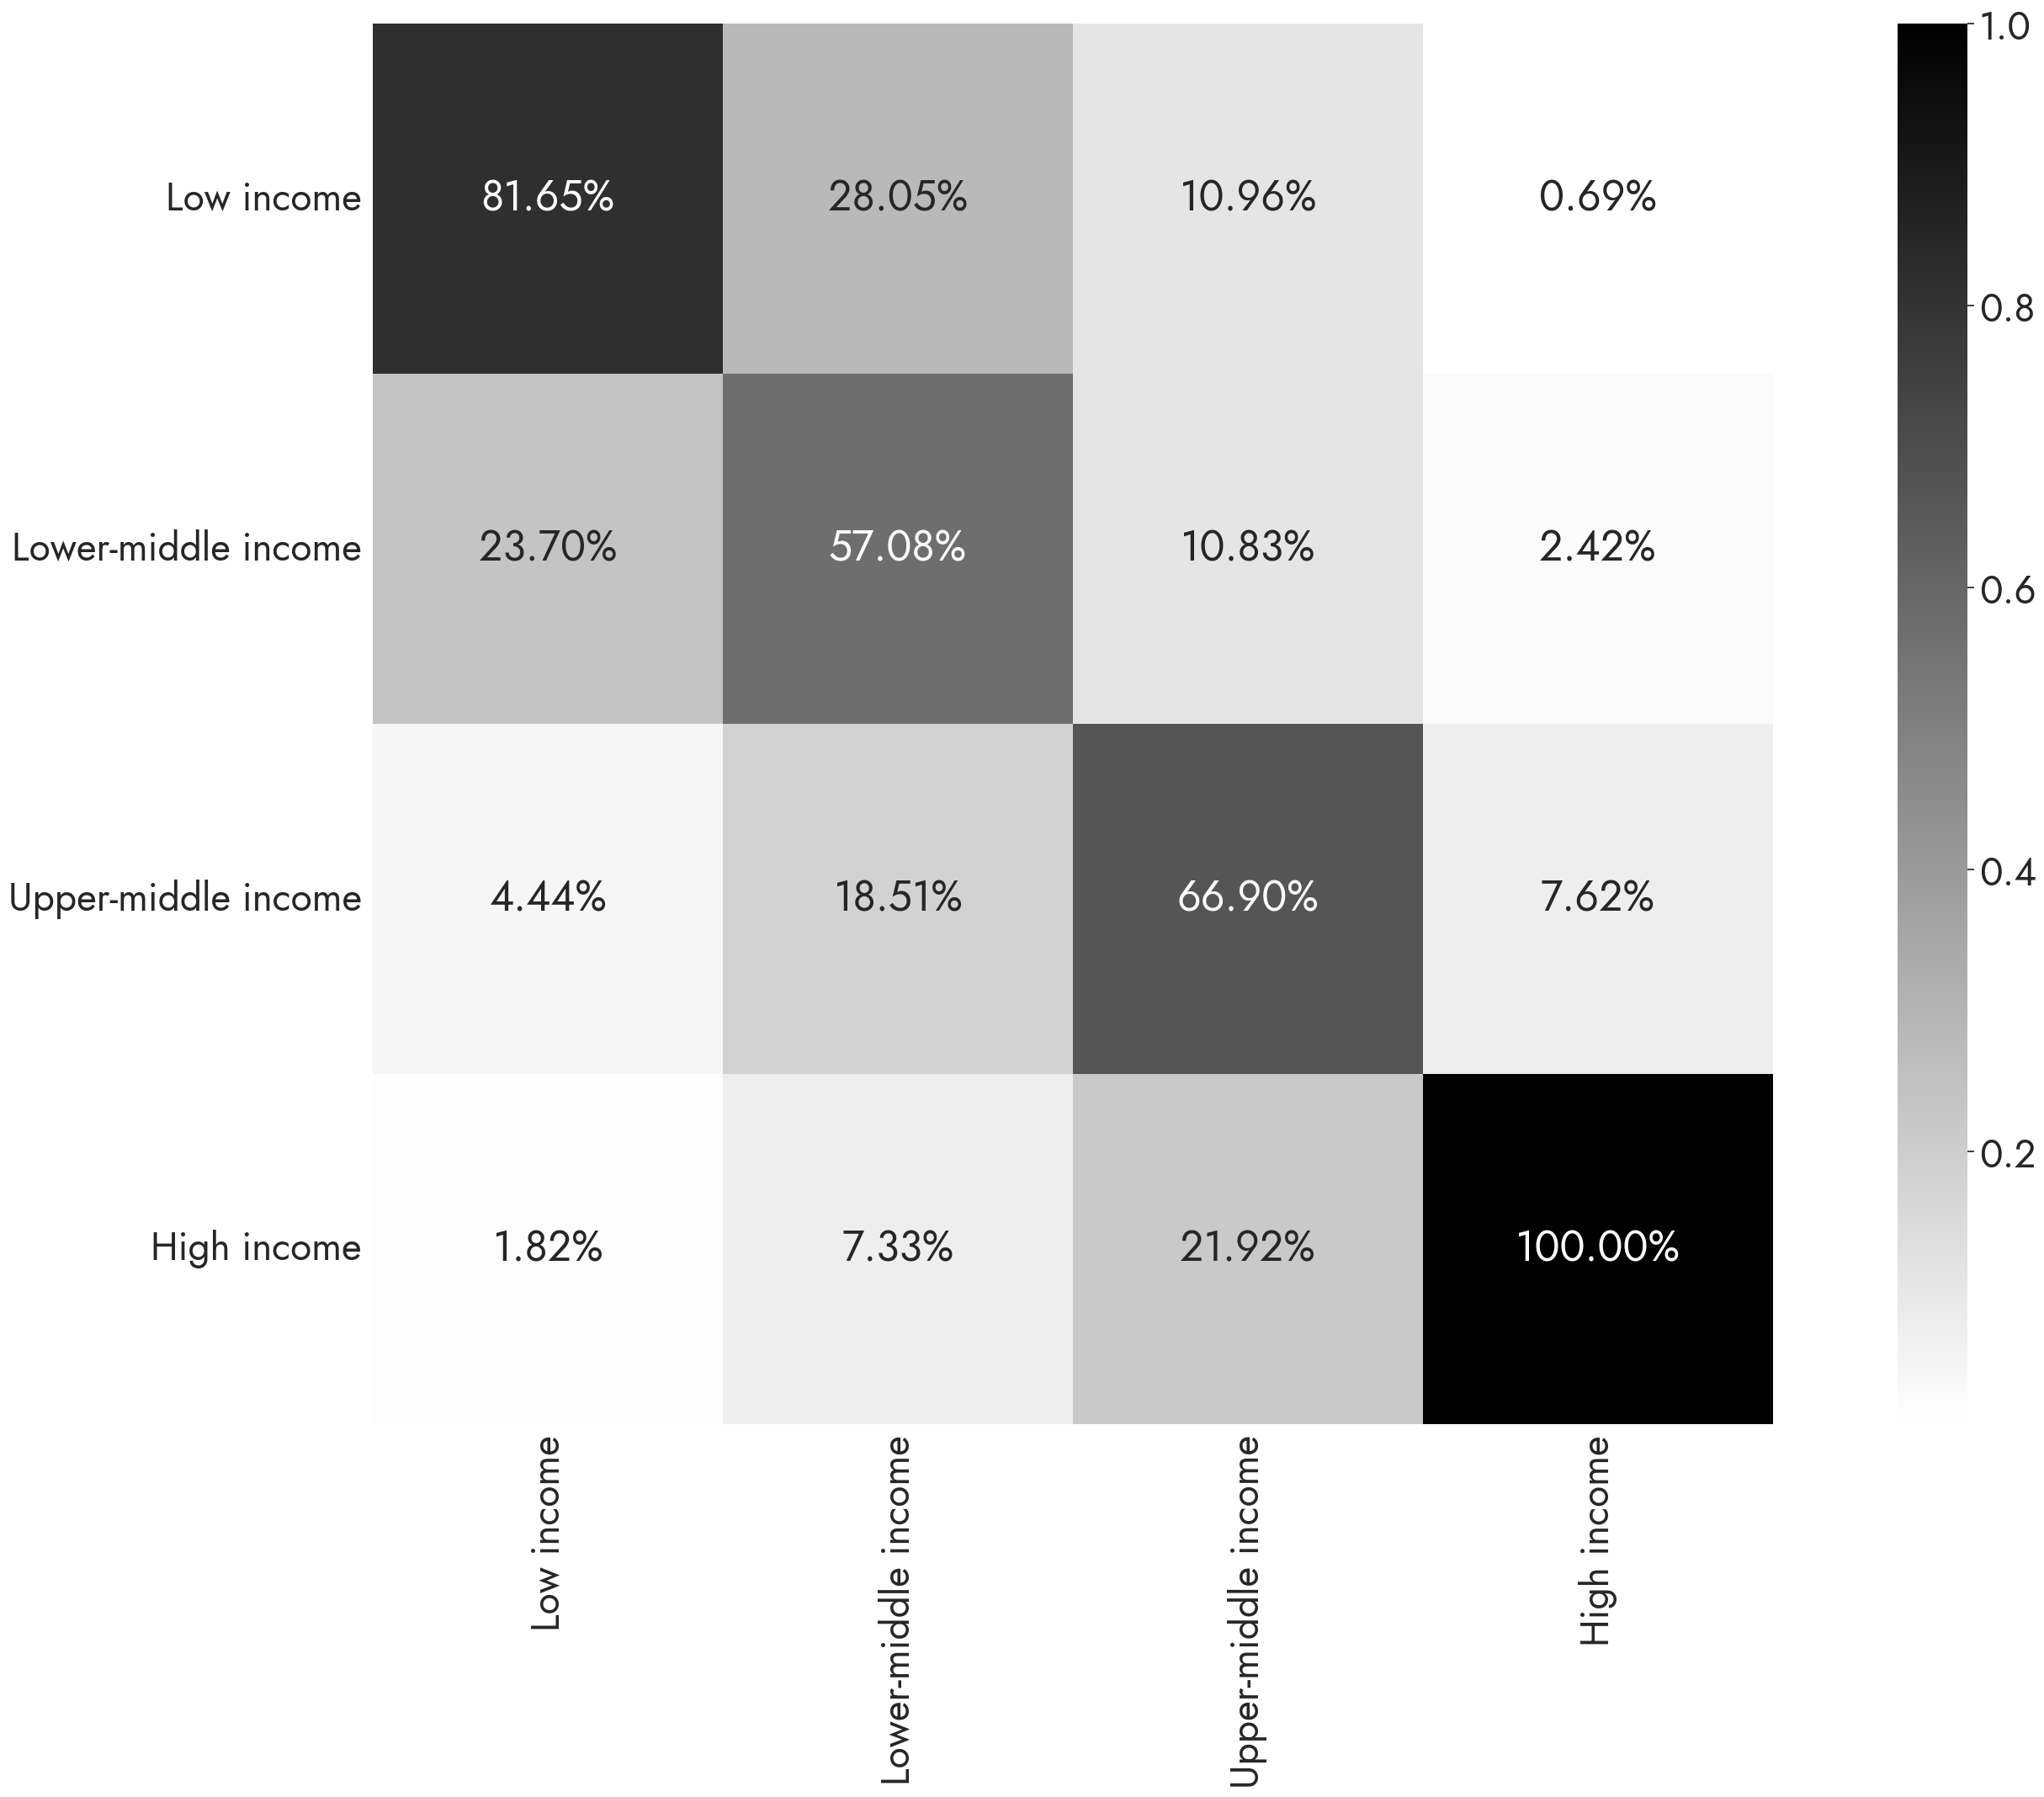

In [50]:
fixed_plot_distribution = sns.heatmap(fixed_distribution / fixed_distribution.max().max(), cmap='gray_r', annot=True, fmt='.2%', square=True)

fixed_plot_distribution.set_xlabel(None);

In [51]:
fixed_plot_distribution.figure.savefig(f'{VISUAL_PATH}/fixed_distribution.png', transparent=True)

Как видно по сводной таблице и по графику, в большинстве случаев модель верно определяет группу.
Теперь визуализируем распределение ошибок в модели

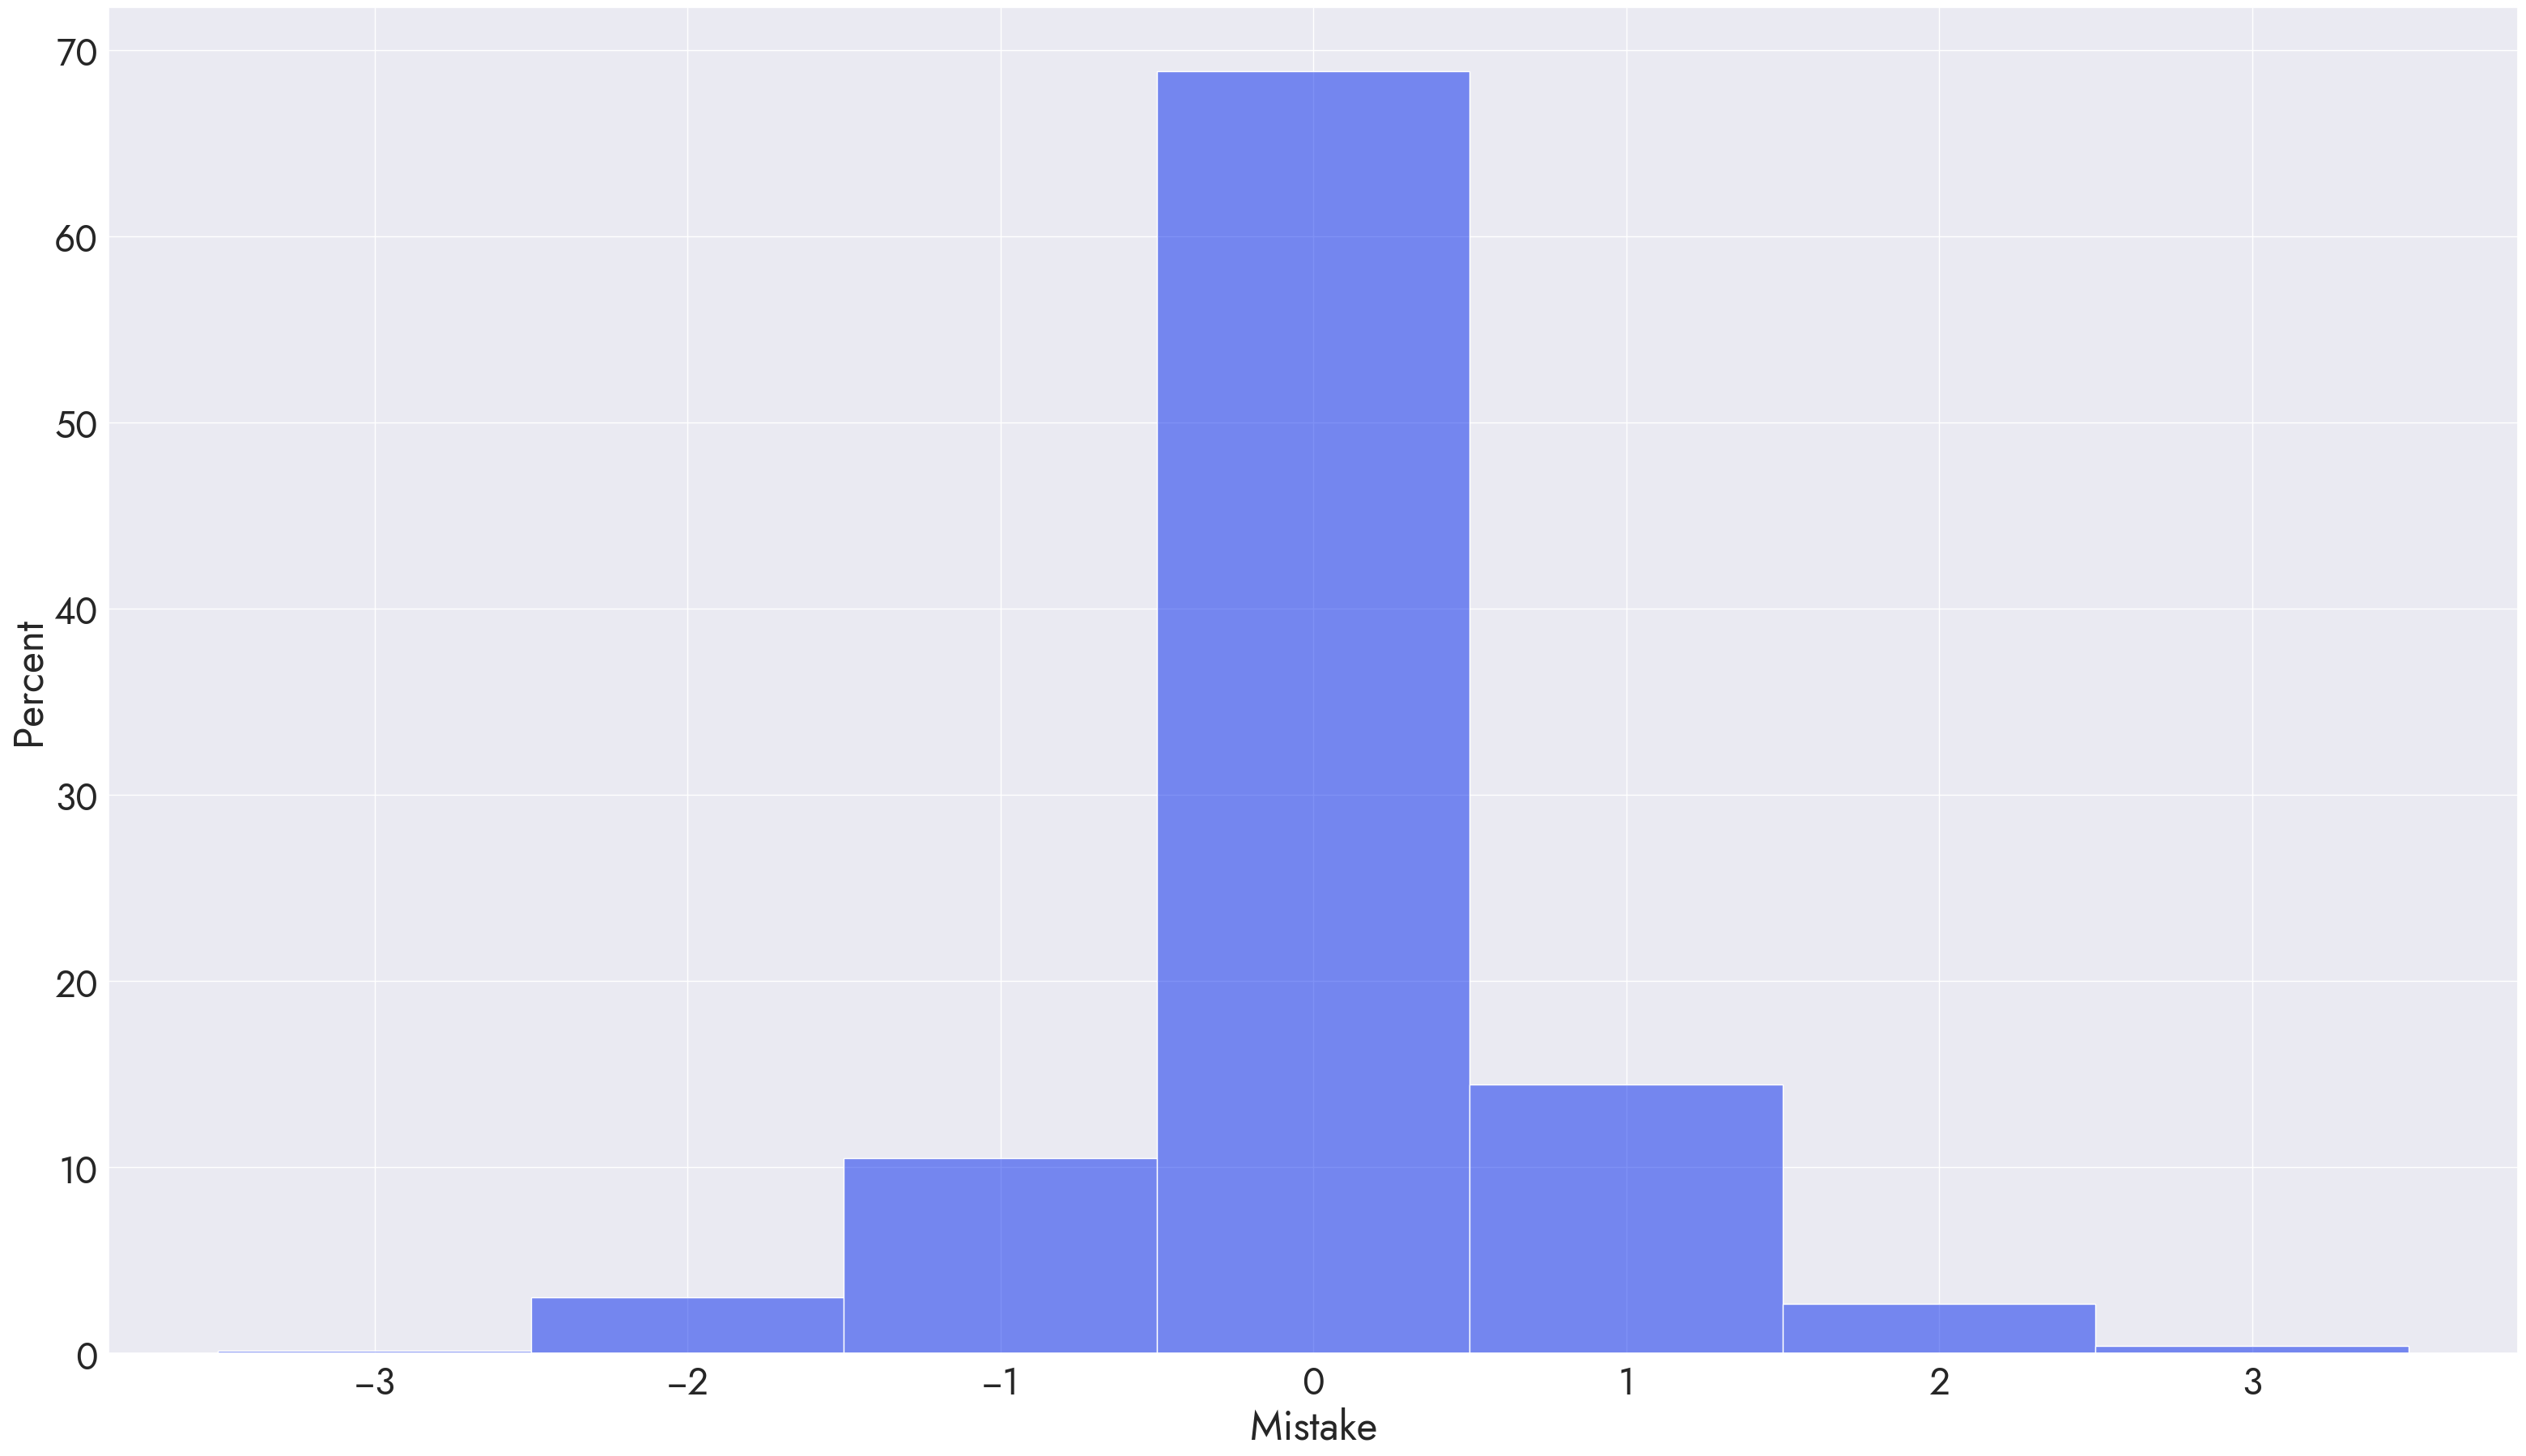

In [52]:
fixed_plot_mistakes = sns.histplot(data=pd.from_dummies(pd.DataFrame(test_predict)) - pd.from_dummies(pd.DataFrame(test_target)), stat='percent', legend=False, discrete=True)

fixed_plot_mistakes.set_xlabel('Mistake');

Большинство наблюдений было предсказано правильно - при этом распределение ошибок имеет нормальный вид, в среднем модель ошибается в рамках соседних групп

In [53]:
fixed_plot_mistakes.figure.savefig(f'{VISUAL_PATH}/fixed_mistakes.png', transparent=True)